## Setup and Imports

In [22]:
# Standard library imports
import os
import sys
from pathlib import Path
from typing import List

# Environment configuration
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# Set rendering backend
if sys.platform == "darwin":
    os.environ["MUJOCO_GL"] = "glfw"
    print("Using macOS with GLFW rendering")
else:
    os.environ["MUJOCO_GL"] = "egl"
    print("Using Linux with EGL rendering")

import warnings

# Suppress pyEDM warnings about no valid prediction indices
warnings.filterwarnings('ignore', message='Simplex: PredictionValid.*')

# Third-party imports
import h5py
import jax
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mediapy as media
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import mujoco
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

# HuggingFace imports
import huggingface_hub as hf_hub

# Logging configuration
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

# Local/project imports
from track_mjx.agent import checkpointing
from track_mjx.analysis import rollout, render

# Set plot style
plt.style.use('seaborn-v0_8')
colorblind_colors = ['#1f77b4', "#ef7307", '#8E44AD']  # Blue, Orange, Purple

def get_joint_qpos(model, qposes, joint_name):
    """Get qpos value(s) for a specific joint by name."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    if joint_id == -1:
        print(f"Joint '{joint_name}' not found!")
        return None

    qpos_addr = model.jnt_qposadr[joint_id]
    joint_type = model.jnt_type[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        return qposes[:, qpos_addr : qpos_addr + 7]
    elif joint_type == mujoco.mjtJoint.mjJNT_HINGE:
        return qposes[:, qpos_addr]
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        return qposes[:, qpos_addr : qpos_addr + 4]
    else:
        return qposes[:, qpos_addr]

Using Linux with EGL rendering


## Configuration

In [2]:
# Checkpoint paths
ckpt_path = Path("/root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/")  # Physics-Aware
joint_ckpt_path = Path("/root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695/")  # Joint Reward Only

# EMG data paths and configuration
MUSCLE_CONFIGS = [
    (5, "Triceps Lateral", "/root/vast/eric/CVAT_mouse_reach/csvs/emg_triceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv", "Triceps"),
    (8, "Biceps Long", "/root/vast/eric/CVAT_mouse_reach/csvs/emg_biceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv", "Biceps"),
]

# Trial data CSV
TRIAL_CSV = '/root/vast/eric/CVAT_mouse_reach/csvs/A36-1_2023-07-18_16-54-01_lightOff_tone_on_off_trials_edited.csv'

# Number of trials to analyze
NUM_TRIALS = 46

print(f"Physics-Aware checkpoint: {ckpt_path}")
print(f"  Exists: {ckpt_path.exists()}")
print(f"Joint Reward Only checkpoint: {joint_ckpt_path}")
print(f"  Exists: {joint_ckpt_path.exists()}")

Physics-Aware checkpoint: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284
  Exists: True
Joint Reward Only checkpoint: /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695
  Exists: True


## Download Reference Data

In [ ]:
# Download all mouse_arm data files from HuggingFace
data_local_dir = Path.cwd().parent
data_download_dir = hf_hub.snapshot_download(
    repo_id="talmolab/MIMIC-MJX", 
    repo_type="dataset",
    allow_patterns="data/mouse_arm/*.h5",
    local_dir=data_local_dir
)
print(f"Downloaded all mouse_arm data to {data_download_dir}")

# List downloaded files
mouse_arm_dir = Path(data_download_dir) / "data" / "mouse_arm"
h5_files = list(mouse_arm_dir.glob("*.h5"))
print(f"Found {len(h5_files)} H5 files")

## Load Checkpoint and Configure Environment

In [4]:
# Load the Physics-Aware checkpoint at step 2
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path, step=2)
cfg = ckpt["cfg"]

# Load the Joint Reward Only checkpoint at step 2
joint_ckpt = checkpointing.load_checkpoint_for_eval(joint_ckpt_path, step=2)
joint_cfg = joint_ckpt["cfg"]

# Update the data path to the downloaded reference data
if h5_files:
    cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    joint_cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    print(f"Using {len(h5_files)} data files")
else:
    print("No H5 files found!")


Loading checkpoint from /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284 at step 2
Loading checkpoint from /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695 at step 2
Using 46 data files


## Create Environment and Rollout Generator

In [5]:
# Create environment and rollout generator for Physics-Aware model
env = rollout.create_environment(cfg)
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
generate_rollout = rollout.create_rollout_generator(
    cfg, 
    env, 
    inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)

# Create environment and rollout generator for Joint Reward Only model
joint_env = rollout.create_environment(joint_cfg)
joint_inference_fn = checkpointing.load_inference_fn(joint_cfg, joint_ckpt["policy"])
joint_generate_rollout = rollout.create_rollout_generator(
    joint_cfg, 
    joint_env, 
    joint_inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)


## Generate Rollout

Generate a single rollout using clip index 20 from the reference data. This will simulate the mouse's reaching behavior based on the trained policy. Feel free to change the clip index to visualize different behaviors in this dataset.

> **Note:** The first time you run this cell, it may take up to 2 minutes to compile the model with JAX, depending on your hardware. Subsequent runs will be much faster.

In [6]:
# generate a single rollout
single_rollout = generate_rollout(clip_idx=20)

## Render and Save Video

Render the rollout as video frames and save it as an MP4 file. The video will be saved in the checkpoint directory.

In [7]:
# render single rollout 
frames, realtime_framerate = render.render_rollout(
    cfg, 
    single_rollout, 
    height=480,
    width=640,
)

# save the video to disk
media.write_video(Path(ckpt_path) / "rollout.mp4", frames, fps=50)
media.show_video(frames, fps=50)

MuJoCo Rendering with Ghost Model...
Rendering every 1 steps; realtime fps: 500


100%|██████████| 120/120 [00:00<00:00, 555.20it/s]


## Generate Batch Rollouts

Generate rollouts for all clips in parallel using JAX's vectorized execution.

In [8]:
# Enable JAX compilation cache for faster subsequent runs
persistent_cache = True
if persistent_cache:
    jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
    jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
    jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
    jax.config.update(
        "jax_persistent_cache_enable_xla_caches",
        "xla_gpu_per_fusion_autotune_cache_dir",
    )

# Create JIT-compiled vectorized rollout functions
jit_vmap_generate_rollout = jax.jit(jax.vmap(generate_rollout))
jit_vmap_joint_generate_rollout = jax.jit(jax.vmap(joint_generate_rollout))

# Generate rollouts for all 46 clips
start_idx, end_idx = 0, 46
clip_idxs = np.arange(start_idx, end_idx)

print("Generating Physics-Aware model rollouts...")
batch_rollout = jit_vmap_generate_rollout(clip_idxs)
print(f"  Keys available: {list(batch_rollout.keys())}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {batch_rollout['qposes_rollout'].shape}")

print("\nGenerating Joint Reward Only model rollouts...")
joint_batch_rollout = jit_vmap_joint_generate_rollout(clip_idxs)
print(f"  Keys available: {list(joint_batch_rollout.keys())}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {joint_batch_rollout['qposes_rollout'].shape}")


Generating Physics-Aware model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)

Generating Joint Reward Only model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)


## Save Rollout Data to H5 File

Save the batch rollout data in a format compatible with the EMG analysis scripts.

In [26]:
# Save rollout data to H5 files for both models

# 1. Save Physics-Aware model rollouts
output_h5_path_physics = ckpt_path / "rollouts_full_mouse_arm_physics_aware.h5"

with h5py.File(output_h5_path_physics, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from batch_rollout
    f.create_dataset("actions", data=np.array(batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(batch_rollout["activations"]["intention"]))

print(f"Saved Physics-Aware rollout data to: {output_h5_path_physics}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")

# 2. Save Joint Reward Only model rollouts
output_h5_path_joint = joint_ckpt_path / "rollouts_full_mouse_arm_joint_only.h5"

with h5py.File(output_h5_path_joint, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from joint_batch_rollout
    f.create_dataset("actions", data=np.array(joint_batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(joint_batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(joint_batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in joint_batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in joint_batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in joint_batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in joint_batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(joint_batch_rollout["activations"]["intention"]))

print(f"Saved Joint Reward Only rollout data to: {output_h5_path_joint}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")

Saved Physics-Aware rollout data to: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/rollouts_full_mouse_arm_physics_aware.h5
  Actions shape: (46, 119, 9)
Saved Joint Reward Only rollout data to: /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695/rollouts_full_mouse_arm_joint_only.h5
  Actions shape: (46, 119, 9)


## Joint Angle Tracking Visualization

Compare reference joint angles with simulation rollout for individual clips.

In [10]:
def plot_joint_angles_comparison(
    qpos_sim,
    qpos_ref, 
    clip_id=0,
    joint_indices=None,
    joint_names=None,
    joint_labels=None,
    save_path=None,
    sim_hz=200,
    max_time=0.25,
    model_name="Simulation",
    model_color=None,
):
    """Plot reference vs rollout joint angles for a given clip.
    
    Args:
        qpos_sim: Simulation qpos array (clips, T, nq)
        qpos_ref: Reference qpos array (clips, T, nq)
        clip_id: Clip index to visualize
        joint_indices: Joint indices to plot
        joint_names: Names for titles
        joint_labels: Labels for y-axis
        save_path: PDF/PNG path to save
        sim_hz: Simulation sampling rate
        max_time: Maximum time to plot in seconds
        model_name: Name of the model for legend
        model_color: Color for the model line
        
    Returns:
        matplotlib.figure.Figure
    """
    # Set default values
    if joint_indices is None:
        joint_indices = [0, 1, 2, 3]
    if joint_names is None:
        joint_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
    if joint_labels is None:
        joint_labels = ["Sh Elevation", "Sh Extension", "Sh Rotation", "Elbow"]
    if model_color is None:
        model_color = colorblind_colors[0]
    
    # Extract clip data
    if clip_id >= qpos_sim.shape[0]:
        raise IndexError(f"clip_id {clip_id} out of range (total={qpos_sim.shape[0]}).")
    
    sim_clip = qpos_sim[clip_id]  # (T, nq)
    ref_clip = qpos_ref[clip_id]  # (T, nq)
    
    # Align DOFs if shapes differ
    nq = min(sim_clip.shape[1], ref_clip.shape[1])
    sim_clip = sim_clip[:, :nq]
    ref_clip = ref_clip[:, :nq]
    
    # Ensure same time length
    min_T = min(sim_clip.shape[0], ref_clip.shape[0])
    sim_clip = sim_clip[:min_T]
    ref_clip = ref_clip[:min_T]
    
    # Create time axis and filter by max_time
    time = np.arange(min_T) / float(sim_hz)
    
    if max_time is not None:
        time_idx = np.searchsorted(time, max_time, side='right')
        time = time[:time_idx]
        sim_clip = sim_clip[:time_idx]
        ref_clip = ref_clip[:time_idx]
    
    # Calculate global y-limits across all joints
    all_vals = []
    for j in joint_indices:
        all_vals.extend(np.degrees(sim_clip[:, j][np.isfinite(sim_clip[:, j])]))
        all_vals.extend(np.degrees(ref_clip[:, j][np.isfinite(ref_clip[:, j])]))
    
    if not all_vals:
        raise ValueError("No finite joint angle data to plot.")
    
    y_min = np.min(all_vals) - 5
    y_max = np.max(all_vals) + 5
    
    # Create figure
    fig, axes = plt.subplots(len(joint_indices), 1, figsize=(3, 8), sharex=True)
    axes = np.atleast_1d(axes)
    
    # Plot each joint
    for i, (j, name, label) in enumerate(zip(joint_indices, joint_names, joint_labels)):
        # Convert to degrees
        ref_deg = np.degrees(ref_clip[:, j])
        sim_deg = np.degrees(sim_clip[:, j])
        
        # Create masks for valid data
        ref_mask = np.isfinite(ref_deg)
        sim_mask = np.isfinite(sim_deg)
        both = ref_mask & sim_mask
        
        # Plot reference
        axes[i].plot(time[ref_mask], ref_deg[ref_mask],
                    color=colorblind_colors[2], label="Reference", linewidth=3, linestyle='--', alpha=0.8)
        
        # Plot simulation
        axes[i].plot(time[sim_mask], sim_deg[sim_mask],
                    color=model_color, label=model_name, linewidth=3)
        
        # Highlight difference
        if np.any(both):
            axes[i].fill_between(time[both], ref_deg[both], sim_deg[both],
                                alpha=0.2, color="gray")
        
        # Configure appearance
        axes[i].set_ylabel(f"{label} (°)", fontsize=18)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_title(f"{name}", fontsize=20, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='both', which='major', labelsize=14)
        
        if max_time is not None:
            axes[i].set_xlim(0, max_time)
        else:
            axes[i].set_xlim(0, time[-1])
        
        # Legend on first subplot
        if i == 0:
            axes[i].legend(loc='upper right', fontsize=14)
    
    # X-axis label
    axes[-1].set_xlabel("Time (seconds)", fontsize=18)
    
    plt.suptitle(f"{model_name}: Joint Angle Tracking (Clip {clip_id})", 
                fontsize=22, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return fig

Creating joint angle tracking plot for both models (clip 0)...


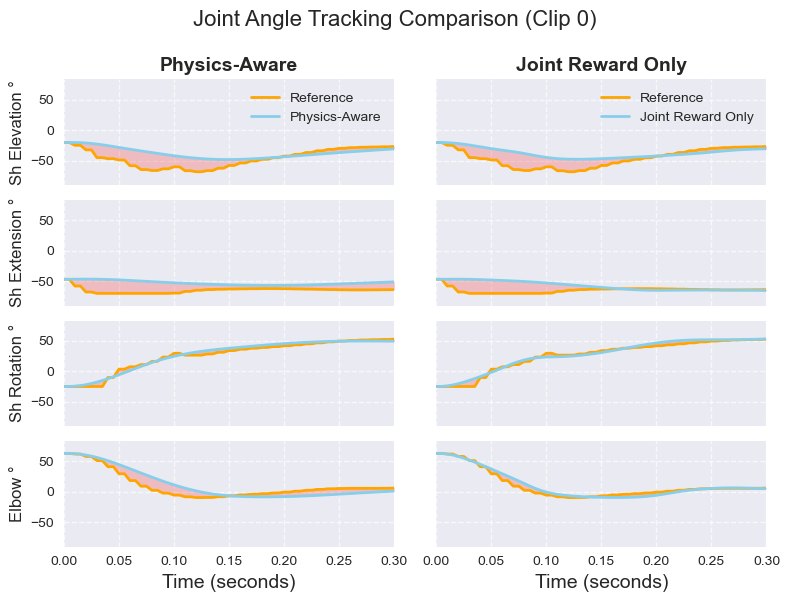

Saved joint angle comparison plot to: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/joint_angle_tracking_comparison_clip0.pdf


In [11]:
# Configuration for joint angle plotting
CLIP_ID = 0  # Clip index to visualize
JOINT_INDICES = [0, 1, 2, 3]  # Joint indices to plot
JOINT_NAMES = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
JOINT_LABELS = ["Sh Elevation", "Sh Extension", "Sh Rotation", "Elbow"]
MAX_TIME = 0.3  # Only show first 250ms

# Create side-by-side comparison plot (2 columns, 4 rows)
print(f"Creating joint angle tracking plot for both models (clip {CLIP_ID})...")

# Extract data
physics_qpos_sim = batch_rollout["qposes_rollout"]
physics_qpos_ref = batch_rollout["qposes_ref"]
joint_qpos_sim = joint_batch_rollout["qposes_rollout"]
joint_qpos_ref = joint_batch_rollout["qposes_ref"]

# Extract clips
physics_sim = physics_qpos_sim[CLIP_ID]
physics_ref = physics_qpos_ref[CLIP_ID]
joint_sim = joint_qpos_sim[CLIP_ID]
joint_ref = joint_qpos_ref[CLIP_ID]

# Ensure same time length for both models
min_T_physics = min(physics_sim.shape[0], physics_ref.shape[0])
min_T_joint = min(joint_sim.shape[0], joint_ref.shape[0])
min_T = min(min_T_physics, min_T_joint)

physics_sim = physics_sim[:min_T]
physics_ref = physics_ref[:min_T]
joint_sim = joint_sim[:min_T]
joint_ref = joint_ref[:min_T]

# Create time axis
sim_hz = 200
time = np.arange(min_T) / float(sim_hz)

# Filter by max time
if MAX_TIME is not None:
    time_idx = np.searchsorted(time, MAX_TIME, side='right')
    time = time[:time_idx]
    physics_sim = physics_sim[:time_idx]
    physics_ref = physics_ref[:time_idx]
    joint_sim = joint_sim[:time_idx]
    joint_ref = joint_ref[:time_idx]

# Calculate global y-limits across all joints and both models
all_vals = []
for j in JOINT_INDICES:
    all_vals.extend(np.degrees(physics_sim[:, j][np.isfinite(physics_sim[:, j])]))
    all_vals.extend(np.degrees(physics_ref[:, j][np.isfinite(physics_ref[:, j])]))
    all_vals.extend(np.degrees(joint_sim[:, j][np.isfinite(joint_sim[:, j])]))
    all_vals.extend(np.degrees(joint_ref[:, j][np.isfinite(joint_ref[:, j])]))

y_min = np.min(all_vals) - 20
y_max = np.max(all_vals) + 20

# Create figure with 2 columns, 4 rows - matching reference style
fig, axes = plt.subplots(4, 2, figsize=(8, 6), sharex=True, sharey=True)

# Plot each joint
for i, (j, name, label) in enumerate(zip(JOINT_INDICES, JOINT_NAMES, JOINT_LABELS)):
    # Physics-Aware (left column)
    ax_physics = axes[i, 0]
    
    physics_ref_deg = np.degrees(physics_ref[:, j])
    physics_sim_deg = np.degrees(physics_sim[:, j])
    
    physics_ref_mask = np.isfinite(physics_ref_deg)
    physics_sim_mask = np.isfinite(physics_sim_deg)
    physics_both = physics_ref_mask & physics_sim_mask
    
    # Plot reference trajectory (orange)
    ax_physics.plot(time[physics_ref_mask], physics_ref_deg[physics_ref_mask],
                   color='orange', label="Reference", linewidth=2)
    
    # Plot simulation trajectory (skyblue)
    ax_physics.plot(time[physics_sim_mask], physics_sim_deg[physics_sim_mask],
                   color='skyblue', label="Physics-Aware", linewidth=2)
    
    # Highlight difference (red shaded area)
    if np.any(physics_both):
        ax_physics.fill_between(time[physics_both], physics_ref_deg[physics_both], 
                               physics_sim_deg[physics_both], alpha=0.2, color="red")
    
    ax_physics.set_ylabel(f"{label} °", fontsize=12)
    ax_physics.set_ylim(y_min, y_max)
    ax_physics.grid(True, linestyle='--', alpha=0.7)
    ax_physics.tick_params(axis='both', which='major', labelsize=10)
    
    # Add title to each row (left side)
    if i == 0:
        ax_physics.set_title("Physics-Aware", fontsize=14, fontweight='bold')
    
    # Add legend to first subplot only
    if i == 0:
        ax_physics.legend(loc='upper right', fontsize=10)
    
    # Joint Reward Only (right column)
    ax_joint = axes[i, 1]
    
    joint_ref_deg = np.degrees(joint_ref[:, j])
    joint_sim_deg = np.degrees(joint_sim[:, j])
    
    joint_ref_mask = np.isfinite(joint_ref_deg)
    joint_sim_mask = np.isfinite(joint_sim_deg)
    joint_both = joint_ref_mask & joint_sim_mask
    
    # Plot reference trajectory (orange)
    ax_joint.plot(time[joint_ref_mask], joint_ref_deg[joint_ref_mask],
                 color='orange', label="Reference", linewidth=2)
    
    # Plot simulation trajectory (skyblue)
    ax_joint.plot(time[joint_sim_mask], joint_sim_deg[joint_sim_mask],
                 color='skyblue', label="Joint Reward Only", linewidth=2)
    
    # Highlight difference (red shaded area)
    if np.any(joint_both):
        ax_joint.fill_between(time[joint_both], joint_ref_deg[joint_both],
                             joint_sim_deg[joint_both], alpha=0.2, color="red")
    
    ax_joint.set_ylim(y_min, y_max)
    ax_joint.grid(True, linestyle='--', alpha=0.7)
    ax_joint.tick_params(axis='both', which='major', labelsize=10)
    
    # Add title to top row
    if i == 0:
        ax_joint.set_title("Joint Reward Only", fontsize=14, fontweight='bold')
    
    # Add legend to first subplot only
    if i == 0:
        ax_joint.legend(loc='upper right', fontsize=10)

# X-axis labels for bottom row only
axes[-1, 0].set_xlabel("Time (seconds)", fontsize=14)
axes[-1, 1].set_xlabel("Time (seconds)", fontsize=14)

# Set x-limits
if MAX_TIME is not None:
    for ax in axes.flat:
        ax.set_xlim(0, MAX_TIME)

plt.suptitle(f"Joint Angle Tracking Comparison (Clip {CLIP_ID})", 
            fontsize=16, y=0.995)
plt.tight_layout()

# Save figure
save_path = ckpt_path / f"joint_angle_tracking_comparison_clip{CLIP_ID}.pdf"
plt.savefig(save_path, bbox_inches="tight", dpi=600)
plt.show()

print(f"Saved joint angle comparison plot to: {save_path}")

## EMG Processing Functions

In [12]:
# Load trial mask
df = pd.read_csv(TRIAL_CSV)

trial_mask = (
    (df['start'].notna()) & 
    (df['end'].notna()) & 
    (df['start'] > 0) & 
    (df['end'] > 0) &
    (df['start'] != df['end'])
)

valid_trials_df = df[trial_mask].copy()
print(f"Valid trials: {len(valid_trials_df)}")

def process_emg_data_individual_trials(emg_file_path, target_samples, num_trials=NUM_TRIALS, duration_ms=250):
    """Process EMG data and return individual trial envelopes"""
    # EMG processing parameters
    fs = 30000
    highpass_cutoff = 20
    lowpass_cutoff = 1000
    envelope_cutoff = 50
    filter_order = 4
    
    # Calculate EMG samples for duration
    emg_duration_samples = int(duration_ms / 1000 * fs)  # Convert ms to samples
    
    # Load EMG data
    emg_data = pd.read_csv(emg_file_path, header=None)
    
    reach_envelopes_processed = []
    
    for i, (idx, row) in enumerate(valid_trials_df.iterrows()):
        if i >= num_trials:
            break
            
        trial_num = idx
        emg_reach_start = int(1/200 * row['start'] * 30000)
        emg_reach_end = emg_reach_start + emg_duration_samples
        
        if trial_num < len(emg_data):
            trial_emg = emg_data.iloc[trial_num, :]
            
            # Process EMG signal
            b, a = signal.butter(filter_order, [highpass_cutoff, lowpass_cutoff], btype='bandpass', fs=fs)
            filtered_emg = signal.filtfilt(b, a, trial_emg)
            
            rectified_emg = np.abs(filtered_emg)
            
            b_env, a_env = signal.butter(filter_order, envelope_cutoff, btype='lowpass', fs=fs)
            emg_envelope = signal.filtfilt(b_env, a_env, rectified_emg)
            
            # Extract envelope during reach period
            if emg_reach_start < len(emg_envelope) and emg_reach_end <= len(emg_envelope):
                reach_envelope = emg_envelope[emg_reach_start:emg_reach_end]
                
                if len(reach_envelope) > 0:
                    # Resample to match target_samples
                    original_time = np.linspace(0, 1, len(reach_envelope))
                    target_time = np.linspace(0, 1, target_samples)
                    resampled_envelope = np.interp(target_time, original_time, reach_envelope)
                    
                    reach_envelopes_processed.append(resampled_envelope)
    
    if not reach_envelopes_processed:
        return None
    
    # Convert to numpy array and normalize
    envelopes_array = np.array(reach_envelopes_processed)
    norm_value = np.percentile(envelopes_array, 98)
    normalized_envelopes = envelopes_array / norm_value
    
    return normalized_envelopes

Valid trials: 46


## Trial-by-Trial EMG vs Simulation Comparison

Compare simulated muscle activations with EMG recordings for individual trials.

In [13]:
# Extract simulation data (first 250ms)
actions = np.clip(batch_rollout["ctrl"], 0.0, 1.0)
n_clips, T, _ = actions.shape

# Only use first 250ms (half the timesteps)
T_half = T // 2
actions = actions[:, :T_half, :]
target_timesteps = 60  # Target 60 timesteps for 250ms at 200 Hz

# Resample to target timesteps if needed
if T_half != target_timesteps:
    print(f"Resampling from {T_half} to {target_timesteps} timesteps")
    original_time = np.linspace(0, 1, T_half)
    target_time = np.linspace(0, 1, target_timesteps)
    
    resampled_actions = np.zeros((n_clips, target_timesteps, actions.shape[2]))
    for clip_idx in range(n_clips):
        for muscle_idx in range(actions.shape[2]):
            f = interp1d(original_time, actions[clip_idx, :, muscle_idx], kind='linear')
            resampled_actions[clip_idx, :, muscle_idx] = f(target_time)
    actions = resampled_actions

time_axis = np.linspace(0, 0.25, target_timesteps)

# Extract Joint Reward Only model data (first 250ms)
print("Processing Joint Reward Only model data...")
joint_actions = np.clip(joint_batch_rollout["ctrl"], 0.0, 1.0)
n_clips_joint, T_joint_full, _ = joint_actions.shape
print(f"Joint Reward Only actions shape: {joint_actions.shape}")

# Only use first 250ms (half the timesteps)
T_joint = T_joint_full // 2
joint_actions = joint_actions[:, :T_joint, :]

# Resample to target timesteps if needed
if T_joint != target_timesteps:
    print(f"Resampling Joint Reward Only from {T_joint} to {target_timesteps} timesteps")
    original_time = np.linspace(0, 1, T_joint)
    target_time = np.linspace(0, 1, target_timesteps)
    
    resampled_joint_actions = np.zeros((n_clips_joint, target_timesteps, joint_actions.shape[2]))
    for clip_idx in range(n_clips_joint):
        for muscle_idx in range(joint_actions.shape[2]):
            f = interp1d(original_time, joint_actions[clip_idx, :, muscle_idx], kind='linear')
            resampled_joint_actions[clip_idx, :, muscle_idx] = f(target_time)
    joint_actions = resampled_joint_actions

# Process EMG data for all muscles
print("Processing EMG data...")
emg_data_by_muscle = {}
for sim_muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
    print(f"  Processing {muscle_name}...")
    emg_traces = process_emg_data_individual_trials(emg_file, target_timesteps, NUM_TRIALS, duration_ms=250)
    emg_data_by_muscle[muscle_name] = emg_traces



Resampling from 59 to 60 timesteps
Processing Joint Reward Only model data...
Joint Reward Only actions shape: (46, 119, 9)
Resampling Joint Reward Only from 59 to 60 timesteps
Processing EMG data...
  Processing Triceps...
  Processing Biceps...


Creating plot for Trial 36...


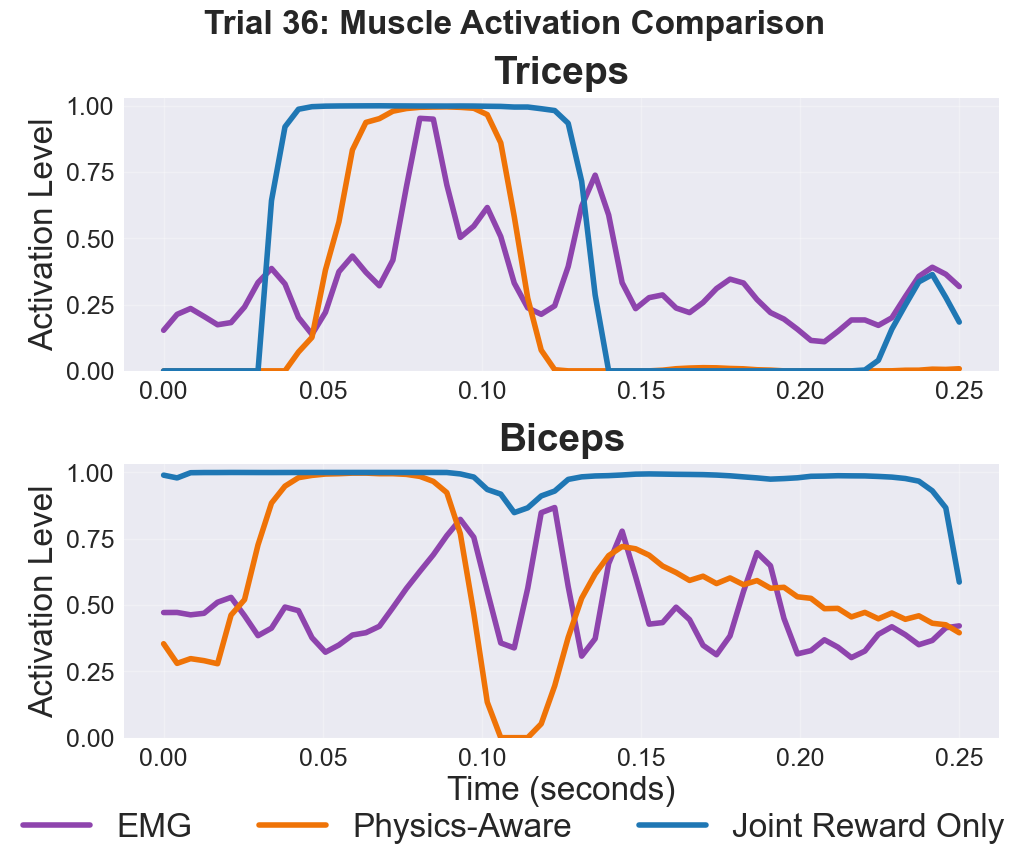

In [14]:
# Plot only clip 20
trial_idx = 35
print(f"Creating plot for Trial {trial_idx + 1}...")

# Create figure (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

legend_handles = []
legend_labels = []
legend_created = False

for muscle_idx, (sim_muscle_idx, sim_name, emg_file, muscle_name) in enumerate(MUSCLE_CONFIGS):
    ax = axes[muscle_idx]
    
    # Plot EMG trace for this trial
    emg_traces = emg_data_by_muscle[muscle_name]
    if emg_traces is not None and trial_idx < len(emg_traces):
        line = ax.plot(time_axis, emg_traces[trial_idx], 
                      color=colorblind_colors[2], linewidth=4.0, label='EMG')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('EMG')
    
    # Plot Physics-Aware model
    if trial_idx < len(actions):
        physics_trace = actions[trial_idx, :, sim_muscle_idx]
        line = ax.plot(time_axis, physics_trace, 
                      color=colorblind_colors[1], linewidth=4.0,
                      label='Physics-Aware')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('Physics-Aware')
    
    # Plot Joint Reward Only model
    if trial_idx < len(joint_actions):
        joint_trace = joint_actions[trial_idx, :, sim_muscle_idx]
        line = ax.plot(time_axis, joint_trace, 
                      color=colorblind_colors[0], linewidth=4.0,
                      label='Joint Reward Only')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('Joint Reward Only')
    
    legend_created = True
    
    # Customize subplot
    ax.set_title(f'{muscle_name}', fontsize=28, fontweight='bold', pad=10)
    ax.set_ylabel('Activation Level', fontsize=24)
    if muscle_idx == len(MUSCLE_CONFIGS) - 1:
        ax.set_xlabel('Time (seconds)', fontsize=24)
    ax.set_ylim(0, 1.03)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
fig.legend(legend_handles, legend_labels, 
          loc='lower center', fontsize=24, 
          bbox_to_anchor=(0.5, -0.05), ncol=3, framealpha=0.9)

# Add overall title
fig.suptitle(f'Trial {trial_idx + 1}: Muscle Activation Comparison', 
            fontsize=24, fontweight='bold', y=1.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)

# Save figure
plt.savefig(ckpt_path / f"trial_{trial_idx + 1}_muscle_comparison.pdf", bbox_inches='tight')
plt.show()

## Average Muscle Activation Across All Clips

Plot the average muscle activation across all clips with standard error shading.

Computing averaged muscle activations across all clips...


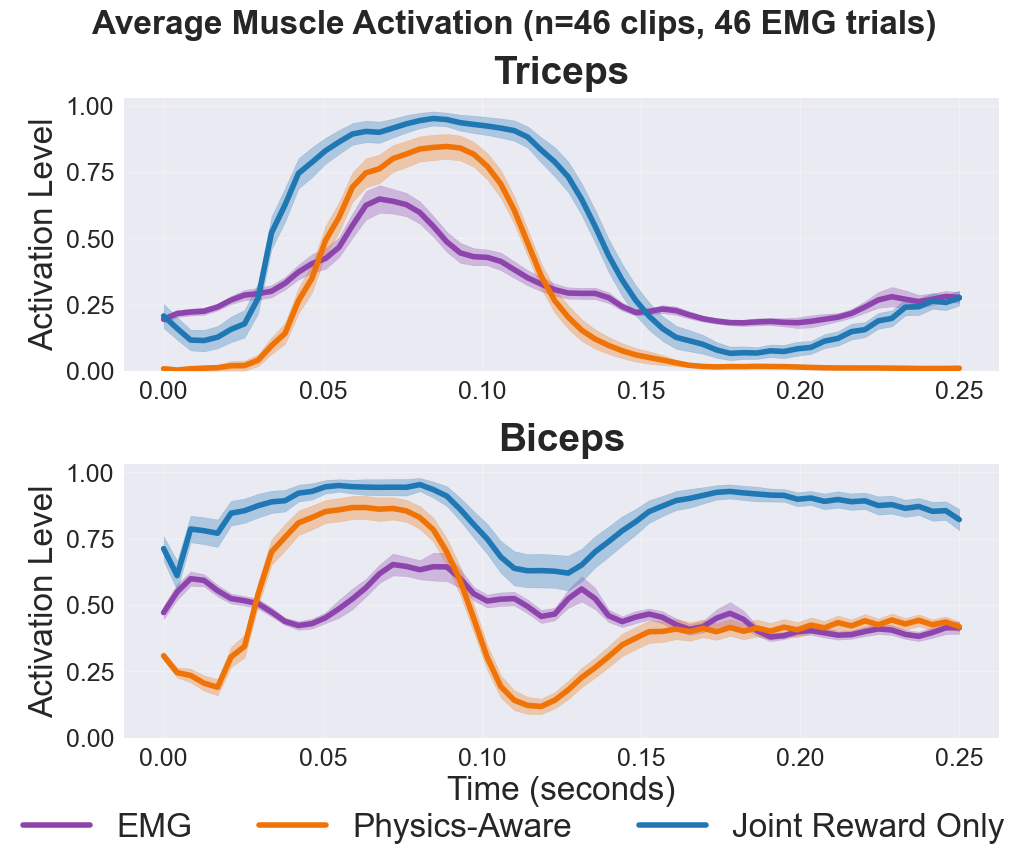

Averaged across 46 simulation clips and 46 EMG trials


In [15]:
# Calculate averages and standard errors across all clips
print("Computing averaged muscle activations across all clips...")

# Create single averaged plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

legend_handles = []
legend_labels = []
legend_created = False

for muscle_idx, (sim_muscle_idx, sim_name, emg_file, muscle_name) in enumerate(MUSCLE_CONFIGS):
    ax = axes[muscle_idx]
    
    # Process EMG data - average across trials
    emg_traces = emg_data_by_muscle[muscle_name]
    if emg_traces is not None and len(emg_traces) > 0:
        emg_mean = np.mean(emg_traces, axis=0)
        emg_sem = np.std(emg_traces, axis=0) / np.sqrt(len(emg_traces))
        
        # Plot EMG with shaded error region (FIXED: match shaded color to line color)
        line = ax.plot(time_axis, emg_mean, 
                      color=colorblind_colors[2], linewidth=4.0, label='EMG')[0]
        ax.fill_between(time_axis, emg_mean - emg_sem, emg_mean + emg_sem,
                        color=colorblind_colors[2], alpha=0.3)  # Changed to match line
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('EMG')
    
    # Process Physics-Aware model - average across clips
    physics_mean = np.mean(actions[:, :, sim_muscle_idx], axis=0)
    physics_sem = np.std(actions[:, :, sim_muscle_idx], axis=0) / np.sqrt(len(actions))
    
    line = ax.plot(time_axis, physics_mean,
                  color=colorblind_colors[1], linewidth=4.0, label='Physics-Aware')[0]
    ax.fill_between(time_axis, physics_mean - physics_sem, physics_mean + physics_sem,
                    color=colorblind_colors[1], alpha=0.3)  # Changed to match line
    if not legend_created:
        legend_handles.append(line)
        legend_labels.append('Physics-Aware')
    
    # Process Joint Reward Only model - average across clips
    joint_mean = np.mean(joint_actions[:, :, sim_muscle_idx], axis=0)
    joint_sem = np.std(joint_actions[:, :, sim_muscle_idx], axis=0) / np.sqrt(len(joint_actions))
    
    line = ax.plot(time_axis, joint_mean,
                  color=colorblind_colors[0], linewidth=4.0, label='Joint Reward Only')[0]
    ax.fill_between(time_axis, joint_mean - joint_sem, joint_mean + joint_sem,
                    color=colorblind_colors[0], alpha=0.3)  # Changed to match line
    if not legend_created:
        legend_handles.append(line)
        legend_labels.append('Joint Reward Only')
    
    legend_created = True
    
    # Customize subplot
    ax.set_title(f'{muscle_name}', fontsize=28, fontweight='bold', pad=10)
    ax.set_ylabel('Activation Level', fontsize=24)
    if muscle_idx == len(MUSCLE_CONFIGS) - 1:
        ax.set_xlabel('Time (seconds)', fontsize=24)
    ax.set_ylim(0, 1.03)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
fig.legend(legend_handles, legend_labels, 
          loc='lower center', fontsize=24, 
          bbox_to_anchor=(0.5, -0.05), ncol=3, framealpha=0.9)

# Add overall title
n_trials_emg = len(emg_traces) if emg_traces is not None else 0
fig.suptitle(f'Average Muscle Activation (n={n_clips} clips, {n_trials_emg} EMG trials)', 
            fontsize=24, fontweight='bold', y=1.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)

# Save figure
plt.savefig(ckpt_path / "average_muscle_comparison.pdf", bbox_inches='tight')
plt.show()

print(f"Averaged across {n_clips} simulation clips and {n_trials_emg} EMG trials")

## Neural Network Activation Analysis

Visualize the high-dimensional activation space using PCA.

Processing neural network activations...
Decoder Layer 0 - Explained variance: [27.2 18.5 14.1]
Decoder Layer 1 - Explained variance: [25.5 15.9 10.8]
Decoder Layer 2 - Explained variance: [55.5 15.7  6.5]
Intentions - Explained variance: [44.3 33.2 20.1]


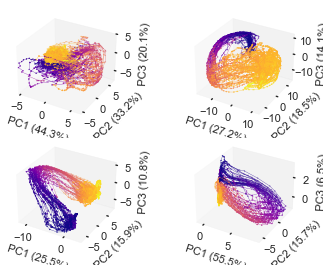

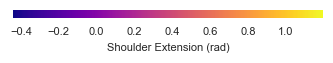

Global shoulder angle range: -0.439 to 1.200 radians


In [16]:
def plot_subplot(data, color_array, title, labels, ax, norm, cmap):
    """Plot 3D trajectory with color-coded points"""
    ax.tick_params(axis="both", which="major", labelsize=8, pad=-4)
    ax.tick_params(axis="z", which="major", labelsize=8, pad=-3)
    ax.set_facecolor("white")
    ax.grid(False)

    x_range = data[:, :, 0].max() - data[:, :, 0].min()
    y_range = data[:, :, 1].max() - data[:, :, 1].min()
    z_range = data[:, :, 2].max() - data[:, :, 2].min()
    ratio = -0.005

    ax.set_xlim(data[:, :, 0].min() - x_range * ratio, data[:, :, 0].max() + x_range * ratio)
    ax.set_ylim(data[:, :, 1].min() - y_range * ratio, data[:, :, 1].max() + y_range * ratio)
    ax.set_zlim(data[:, :, 2].min() - z_range * ratio, data[:, :, 2].max() + z_range * ratio)

    ax.set_xlabel(labels[0], fontsize=8, labelpad=-8, rotation=-16)
    ax.set_ylabel(labels[1], fontsize=8, labelpad=-8, rotation=55)
    ax.set_zlabel(labels[2], fontsize=8, labelpad=-8, rotation=90)

    for n in range(data.shape[0]):
        d = data[n]
        lc_color = cmap(norm(color_array[n, :-1]))
        line_data = np.stack([d[:-1], d[1:]], axis=1)
        lc = Line3DCollection(line_data, colors=lc_color, linewidths=0.2)
        ax.add_collection3d(lc)
        ax.scatter(d[:, 0], d[:, 1], d[:, 2], c=color_array[n], cmap=cmap, norm=norm, s=0.5)

def perform_pca_batch(data, layer_name):
    """Perform PCA on batch activation data"""
    pca = PCA(n_components=3)
    concatenated_data = data.reshape(-1, data.shape[-1])
    pca_result = pca.fit_transform(concatenated_data)
    
    batch_size, timesteps, _ = data.shape
    pca_result = pca_result.reshape(batch_size, timesteps, 3)
    
    explained_variance = np.round(pca.explained_variance_ratio_ * 100, 1)
    print(f"{layer_name} - Explained variance: {explained_variance}")
    return pca_result, explained_variance

# Extract activation data
print("Processing neural network activations...")
decoder_layer_0_data = batch_rollout["activations"]["decoder"]["layer_0"]
decoder_layer_1_data = batch_rollout["activations"]["decoder"]["layer_1"] 
decoder_layer_2_data = batch_rollout["activations"]["decoder"]["layer_2"]
intentions_data = batch_rollout["activations"]["intention"]
qpos_data = batch_rollout["qposes_rollout"]

# Find minimum timesteps
min_timesteps = min(
    decoder_layer_0_data.shape[1],
    decoder_layer_1_data.shape[1], 
    decoder_layer_2_data.shape[1],
    intentions_data.shape[1],
    qpos_data.shape[1]
)

# Truncate all arrays
decoder_layer_0_truncated = decoder_layer_0_data[:, :min_timesteps, :]
decoder_layer_1_truncated = decoder_layer_1_data[:, :min_timesteps, :]
decoder_layer_2_truncated = decoder_layer_2_data[:, :min_timesteps, :]
intentions_truncated = intentions_data[:, :min_timesteps, :]
qpos_data_truncated = qpos_data[:, :min_timesteps, :]

# Perform PCA
decoder_layer_0, vars_decoder_layer_0 = perform_pca_batch(decoder_layer_0_truncated, "Decoder Layer 0")
decoder_layer_1, vars_decoder_layer_1 = perform_pca_batch(decoder_layer_1_truncated, "Decoder Layer 1")
decoder_layer_2, vars_decoder_layer_2 = perform_pca_batch(decoder_layer_2_truncated, "Decoder Layer 2")
intentions_pca, vars_intentions_pca = perform_pca_batch(intentions_truncated, "Intentions")

# Create data with shoulder extension angle
qpos_data_truncated = np.array(qpos_data_truncated)
decoder_0_with_angle = np.concatenate([decoder_layer_0, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
decoder_1_with_angle = np.concatenate([decoder_layer_1, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
decoder_2_with_angle = np.concatenate([decoder_layer_2, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)
intentions_with_angle = np.concatenate([intentions_pca, qpos_data_truncated[:, :, 2][..., np.newaxis]], axis=2)

# Dataset configurations
datasets = {
    "intentions": {"data": intentions_with_angle, "title": "Intentions", "var_exp": vars_intentions_pca},
    "decoder_layer_0": {"data": decoder_0_with_angle, "title": "Decoder Layer 1", "var_exp": vars_decoder_layer_0},
    "decoder_layer_1": {"data": decoder_1_with_angle, "title": "Decoder Layer 2", "var_exp": vars_decoder_layer_1},
    "decoder_layer_2": {"data": decoder_2_with_angle, "title": "Decoder Layer 3", "var_exp": vars_decoder_layer_2},
}

# Find global min/max for colorbar
all_shoulder_angles = [config["data"][:, :, 3] for config in datasets.values()]
global_min = min(angles.min() for angles in all_shoulder_angles)
global_max = max(angles.max() for angles in all_shoulder_angles)

# Create colormap
norm = plt.Normalize(global_min, global_max)
cmap = plt.cm.plasma

# Create 2x2 subplot figure
fig = plt.figure(figsize=(3.75, 3))
fig.patch.set_facecolor("white")
subplot_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (key, config) in enumerate(datasets.items()):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    
    trajectory_data = config["data"][:, :, :3]
    shoulder_angles = config["data"][:, :, 3]
    var_exp = config["var_exp"]
    
    labels = [f"PC1 ({var_exp[0]:.1f}%)", f"PC2 ({var_exp[1]:.1f}%)", f"PC3 ({var_exp[2]:.1f}%)"]
    
    plot_subplot(trajectory_data, shoulder_angles, config["title"], labels, ax, norm, cmap)
    
    if key == "intentions":
        ax.set_xticks([-5, 0, 5])
        ax.set_yticks([-5, 0, 5])
        ax.set_zticks([-5, 0, 5])

plt.subplots_adjust(left=0.00, right=0.95, top=0.90, bottom=0.10, wspace=0.0, hspace=0.15)
plt.savefig(ckpt_path / "arm_latent_space_2x2_batch.pdf", pad_inches=0.2)
plt.show()

# Create colorbar
fig_cbar, ax_cbar = plt.subplots(figsize=(4, 0.1))
fig_cbar.patch.set_facecolor("white")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax_cbar, orientation="horizontal")
plt.tick_params(labelsize=8)
cbar.set_label("Shoulder Extension (rad)", fontsize=8)
ax_cbar.set_frame_on(False)
plt.savefig(ckpt_path / "arm_latent_space_colorbar_batch.pdf", bbox_inches="tight")
plt.show()

print(f"Global shoulder angle range: {global_min:.3f} to {global_max:.3f} radians")


EMG ERROR ANALYSIS
Physics-Aware model: 46 clips, 119 timesteps
Joint Reward Only model: (46, 119, 9)

Processing EMG data for error analysis...
  Processing Triceps...
  Processing Biceps...

Calculating errors for Physics-Aware...
  Triceps: Processed 46 clips
  Biceps: Processed 46 clips

Calculating errors for Joint Reward Only...
  Triceps: Processed 46 clips
  Biceps: Processed 46 clips


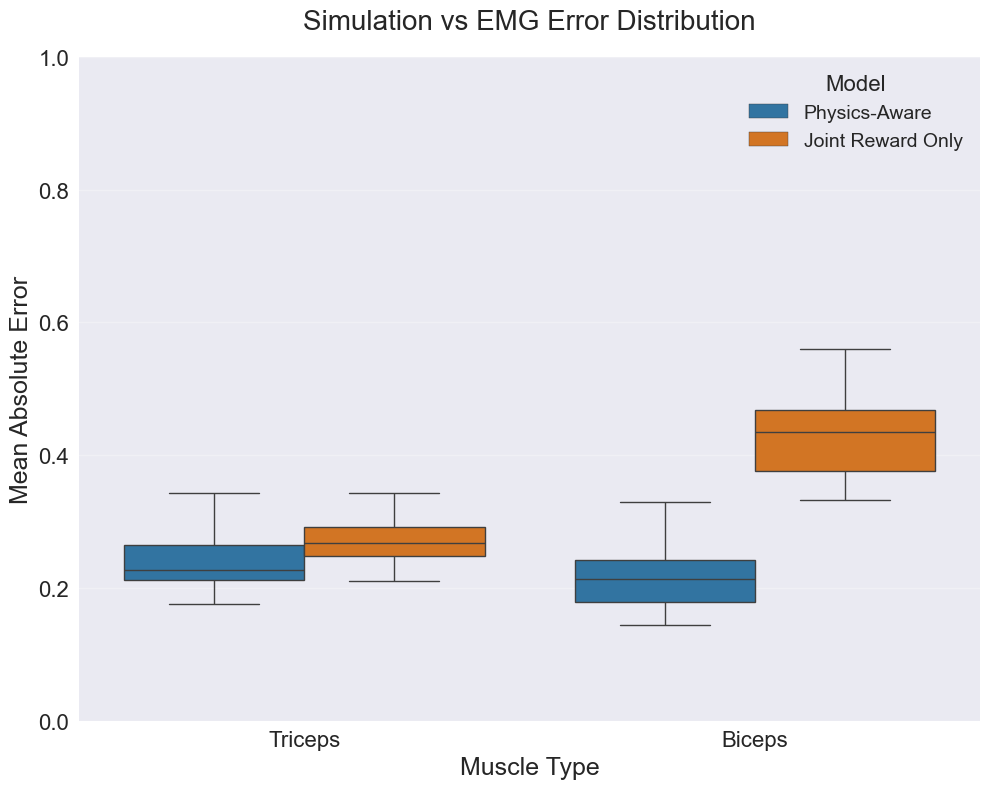


ERROR ANALYSIS SUMMARY

Physics-Aware:
--------------------------------------------------

  Triceps:
    Mean:    0.2405
    Median:  0.2276
    Std:     0.0442
    Q1:      0.2120
    Q3:      0.2652

  Biceps:
    Mean:    0.2255
    Median:  0.2131
    Std:     0.0698
    Q1:      0.1790
    Q3:      0.2414

Joint Reward Only:
--------------------------------------------------

  Triceps:
    Mean:    0.2783
    Median:  0.2678
    Std:     0.0501
    Q1:      0.2480
    Q3:      0.2918

  Biceps:
    Mean:    0.4282
    Median:  0.4351
    Std:     0.0558
    Q1:      0.3768
    Q3:      0.4674

COMPARISON:
--------------------------------------------------

Triceps:
  Joint Reward Only Mean Error:  0.2783
  Physics-Aware Mean Error:      0.2405
  Improvement:                   0.0378
  Percent Change:                13.58%

Biceps:
  Joint Reward Only Mean Error:  0.4282
  Physics-Aware Mean Error:      0.2255
  Improvement:                   0.2027
  Percent Change:            

In [ ]:
# --------------------------- EMG ERROR ANALYSIS -----------------------------------
print("\n" + "="*80)
print("EMG ERROR ANALYSIS")
print("="*80)

# Use full 500ms duration for error analysis
actions_full = np.clip(batch_rollout["ctrl"], 0.0, 1.0)
n_clips_full, T_full, _ = actions_full.shape
target_samples_full = T_full  # Use full simulation timesteps (100 for 500ms)

print(f"Physics-Aware model: {n_clips_full} clips, {T_full} timesteps")

# Extract Joint Reward Only model data (full duration)
joint_actions_full = np.clip(joint_batch_rollout["ctrl"], 0.0, 1.0)
print(f"Joint Reward Only model: {joint_actions_full.shape}")

# Process EMG data for full duration (500ms)
print("\nProcessing EMG data for error analysis...")
emg_data_full = {}
for sim_muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
    print(f"  Processing {muscle_name}...")
    emg_traces = process_emg_data_individual_trials(emg_file, target_samples_full, 
                                                     num_trials=n_clips_full, 
                                                     duration_ms=500)
    emg_data_full[muscle_name] = emg_traces

# Calculate errors for both models
all_errors_data = []

for condition_name, actions_data in [("Physics-Aware", actions_full), 
                                     ("Joint Reward Only", joint_actions_full)]:
    print(f"\nCalculating errors for {condition_name}...")
    
    for muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
        emg_traces = emg_data_full[muscle_name]
        
        if emg_traces is not None:
            # Get simulation traces for this muscle
            sim_traces = actions_data[:, :, muscle_idx]
            
            # Match number of clips between sim and EMG
            n_clips_to_use = min(len(sim_traces), len(emg_traces))
            
            # Calculate error for each clip
            for clip_idx in range(n_clips_to_use):
                sim_trace = sim_traces[clip_idx, :]
                emg_trace = emg_traces[clip_idx, :]
                
                # Ensure same length
                min_len = min(len(sim_trace), len(emg_trace))
                sim_trace = sim_trace[:min_len]
                emg_trace = emg_trace[:min_len]
                
                # Calculate mean absolute error
                clip_error = np.mean(np.abs(sim_trace - emg_trace))
                
                all_errors_data.append({
                    'Condition': condition_name,
                    'Muscle': muscle_name,
                    'Error': clip_error,
                    'Clip': clip_idx
                })
            
            print(f"  {muscle_name}: Processed {n_clips_to_use} clips")

# Create DataFrame
df_errors = pd.DataFrame(all_errors_data)

# Create grouped box and whisker plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create grouped box plot
box_plot = sns.boxplot(data=df_errors, x='Muscle', y='Error', hue='Condition',
                      palette=['#1f77b4', "#ef7307"],  # Blue for Physics-Aware, Orange for Joint Reward Only
                      ax=ax, showfliers=False)

# Customize the plot
ax.set_xlabel('Muscle Type', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.set_title('Simulation vs EMG Error Distribution', fontsize=20, pad=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(0, 0.7)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Model', title_fontsize=16, fontsize=14, loc='upper right')

# Add grid
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(ckpt_path / "emg_error_boxplot.pdf", bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

for condition in df_errors['Condition'].unique():
    print(f"\n{condition}:")
    print("-" * 50)
    
    condition_data = df_errors[df_errors['Condition'] == condition]
    
    for muscle in condition_data['Muscle'].unique():
        muscle_data = condition_data[condition_data['Muscle'] == muscle]['Error']
        print(f"\n  {muscle}:")
        print(f"    Mean:    {muscle_data.mean():.4f}")
        print(f"    Median:  {muscle_data.median():.4f}")
        print(f"    Std:     {muscle_data.std():.4f}")
        print(f"    Q1:      {muscle_data.quantile(0.25):.4f}")
        print(f"    Q3:      {muscle_data.quantile(0.75):.4f}")

# Comparison analysis
print(f"\n{'COMPARISON:'}")
print("-" * 50)

for muscle in df_errors['Muscle'].unique():
    print(f"\n{muscle}:")
    
    physics_aware = df_errors[(df_errors['Condition'] == 'Physics-Aware') & 
                              (df_errors['Muscle'] == muscle)]['Error']
    joint_only = df_errors[(df_errors['Condition'] == 'Joint Reward Only') & 
                           (df_errors['Muscle'] == muscle)]['Error']
    
    if len(physics_aware) > 0 and len(joint_only) > 0:
        improvement = joint_only.mean() - physics_aware.mean()
        percent_change = (improvement / joint_only.mean()) * 100
        
        print(f"  Joint Reward Only Mean Error:  {joint_only.mean():.4f}")
        print(f"  Physics-Aware Mean Error:      {physics_aware.mean():.4f}")
        print(f"  Improvement:                   {improvement:.4f}")
        print(f"  Percent Change:                {percent_change:.2f}%")

print("="*80)

# PyEDM Analysis

PyEDM ANALYSIS - Physics-Aware Model
Helper functions loaded successfully

Preparing data for PyEDM analysis...

EMG data shapes:
  Triceps: (46, 60)
  Biceps: (46, 60)
Qpos shape: (46, 60, 4)
Actions shape: (46, 60, 9)
Debug shapes: EMG=46x60, qpos=46x60x4, actions=46x60x9
Using common dimensions: N=46, T=60

DataFrame shape: (20760, 16)
Training range: 1 18000
Testing range: 18001 20760
Number of clips: 46

ANALYSIS 1: PREDICTING SIMULATED MUSCLE ACTIONS FROM JOINT ANGLES
Using corrected ranges:
  Library: 1 14730
  Prediction: 14731 20759

Predicting Biceps_Long from joint angles...


/tmp/ipykernel_1049120/1067919141.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


  Biceps_Long: ρ = 0.802
  Non-NaN predictions: 795 / 6030

Predicting Triceps_Long from joint angles...
  Triceps_Long: ρ = 0.789
  Non-NaN predictions: 795 / 6030

--------------------------------------------------------------------------------
Running shuffled control comparison...
--------------------------------------------------------------------------------
  Shuffling Biceps_Long...
  Biceps_Long: Original ρ = 0.802, Shuffled ρ = 0.024
  Shuffling Triceps_Long...
  Triceps_Long: Original ρ = 0.789, Shuffled ρ = 0.009

ANALYSIS 2: PREDICTING REAL EMG FROM REF JOINT ANGLES + ACTIONS

Creating lagged embedding columns...
Total embedding dimensions: 62
  Joint embeddings: 8
  Action embeddings: 54


Simplex (joints+actions → EMG):   0%|          | 0/2 [00:00<?, ?it/s]

  Triceps: ρ = 0.610, Non-NaN: 760 / 6030


Simplex (joints+actions → EMG): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

  Biceps: ρ = 0.341, Non-NaN: 760 / 6030

--------------------------------------------------------------------------------
Running shuffled control comparison...
--------------------------------------------------------------------------------
  Shuffling Triceps...


  Triceps: Original ρ = 0.610, Shuffled ρ = -0.016
  Shuffling Biceps...
  Biceps: Original ρ = 0.341, Shuffled ρ = -0.012

SIMPLEX ANALYSES COMPLETE

CREATING COMPREHENSIVE VISUALIZATION

Prediction range: 14731 to 20759
Clips in prediction range:
  Clip 33: rows 15181-15240
  Clip 34: rows 15641-15700
  Clip 35: rows 16101-16160
  Clip 36: rows 16561-16620
  Clip 37: rows 17021-17080
  Clip 38: rows 17481-17540
  Clip 39: rows 17941-18000
  Clip 40: rows 18401-18460
  Clip 41: rows 18861-18920
  Clip 42: rows 19321-19380
  Clip 43: rows 19781-19840
  Clip 44: rows 20241-20300
  Clip 45: rows 20701-20760

Displaying clip 34:
  DataFrame rows: 15641 to 15700
  Offset in prediction arrays: 910 to 969
  Clip length: 59 timesteps


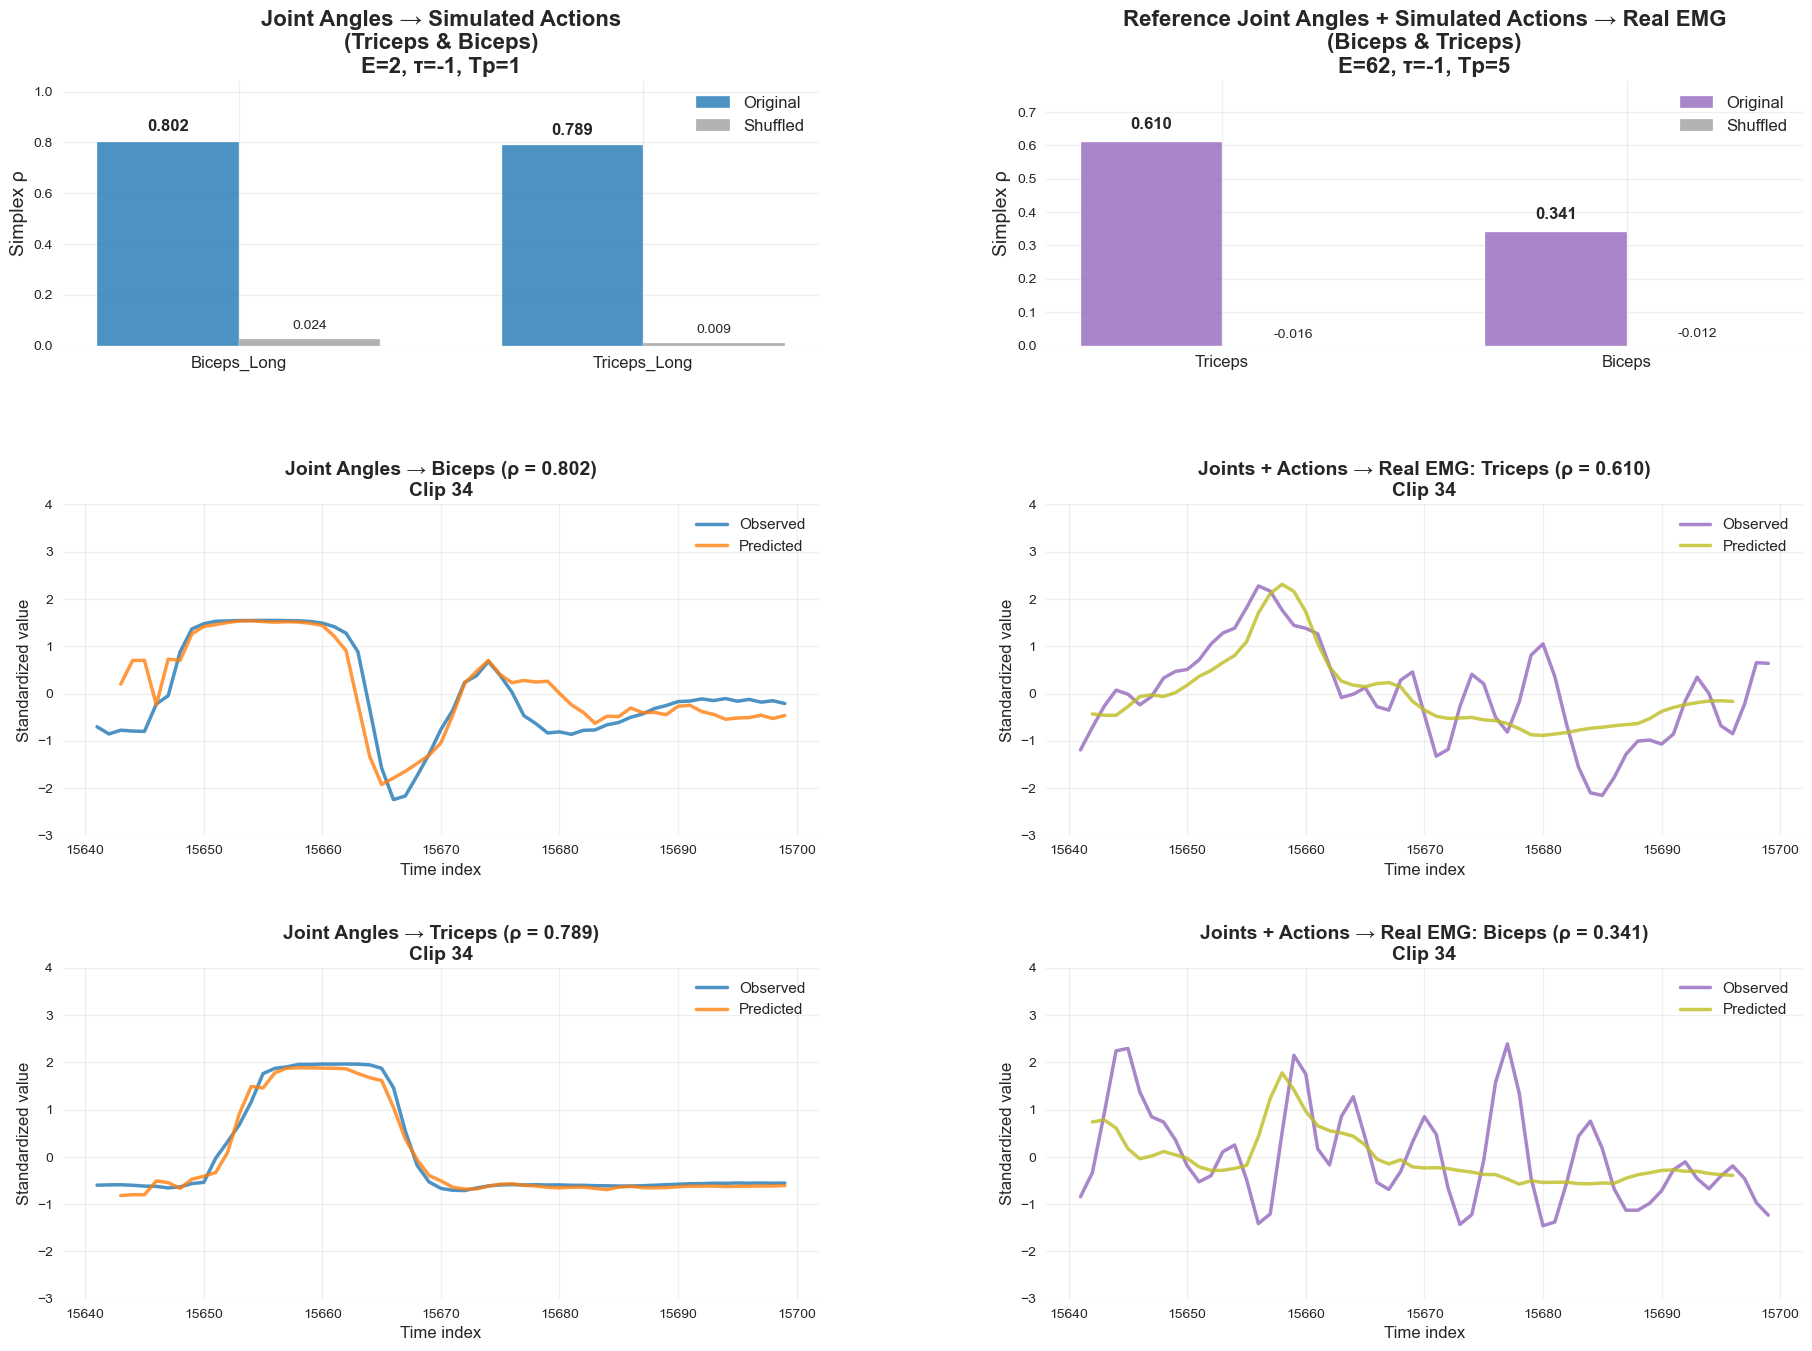


Figure saved to: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/pyedm_analysis/comprehensive_simplex_analysis.png


In [ ]:
# ========================================================================================
# COMPREHENSIVE PyEDM ANALYSIS - Physics-Aware Model
# ========================================================================================

import seaborn as sns
from pyEDM import Simplex
from tqdm import tqdm

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Configuration
OUT_DIR = ckpt_path / "pyedm_analysis"
OUT_DIR.mkdir(exist_ok=True)

# Use existing data from notebook
qpos_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
action_names = [f"act{i}" for i in range(9)]
muscle_names = ["Pec_C", "Lat", "PD", "AD", "MD", "Triceps_Lateral", "Triceps_Long", "Brachialis", "Biceps_Long"]

print("="*80)
print("PyEDM ANALYSIS - Physics-Aware Model")
print("="*80)

# ========================================================================================
# HELPER FUNCTIONS
# ========================================================================================

def _safe_corr(y, yhat, min_pairs=10):
    """Calculate correlation safely handling NaN values."""
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual lags [t0, t-1*lag_step, ... t-(E-1)*lag_step] as separate columns."""
    if prefix is None: prefix = base_col
    cols = []
    for k in range(E):
        name = f"{prefix}_t{-k}"
        df[name] = df[base_col].shift(k * lag_step)
        cols.append(name)
    return cols

def concat_nan_padded_full(emg_stack, qpos_stack, act_stack, pad=100, standardize=True):
    """Build a long NaN-padded DF with EMG, qpos, and actions."""
    emg_names = list(emg_stack.keys())
    
    # Get time dimensions from each data source
    N_emg, T_emg = next(iter(emg_stack.values())).shape
    N_qpos, T_qpos, J = qpos_stack.shape
    N_act, T_act, A = act_stack.shape
    
    print(f"Debug shapes: EMG={N_emg}x{T_emg}, qpos={N_qpos}x{T_qpos}x{J}, actions={N_act}x{T_act}x{A}")
    
    # Ensure consistent N (number of trials)
    N = min(N_emg, N_qpos, N_act)
    
    # Ensure consistent T (time dimension) by taking the minimum
    T = min(T_emg, T_qpos, T_act)
    print(f"Using common dimensions: N={N}, T={T}")
    
    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J): pad_df[qpos_names[j]] = np.nan
            for a in range(A): pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c][:T]  # Truncate to common time dimension
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :T, j]  # Truncate to common time dimension
            data[qpos_names[j]] = zscore(k) if standardize else k
        # actions
        for a in range(A):
            v = act_stack[c, :T, a]  # Truncate to common time dimension
            data[action_names[a]] = zscore(v) if standardize else v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

def simplex_multicolumn_prediction(df, source_cols, target_col, lib, pred, E=6, tau=-1, Tp=1):
    """Use all source columns together to predict a single target."""
    columns_str = " ".join(source_cols)
    
    pred_df = Simplex(
        dataFrame=df, lib=lib, pred=pred,
        columns=columns_str, target=target_col,
        E=E, tau=tau, Tp=Tp,
        ignoreNan=True, showPlot=False
    )
    
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rho = _safe_corr(obs, hat, min_pairs=10)
    
    return rho, pred_df, obs, hat

def shuffled_simplex_comparison(df, source_cols, target_col, lib, pred, E=6, tau=-1, Tp=1, 
                                n_shuffles=10, seed=42):
    """Run simplex on randomly shuffled data as a control."""
    np.random.seed(seed)
    
    rho_shuffled_list = []
    
    for i in range(n_shuffles):
        # Create a copy to shuffle
        df_shuffled = df.copy()
        
        # Get indices where target is not NaN
        valid_idx = df_shuffled[df_shuffled[target_col].notna()].index
        
        # Shuffle the target column (only non-NaN values)
        shuffled_values = df_shuffled.loc[valid_idx, target_col].values.copy()
        np.random.shuffle(shuffled_values)
        df_shuffled.loc[valid_idx, target_col] = shuffled_values
        
        # Shuffle each source column
        for col in source_cols:
            valid_idx = df_shuffled[df_shuffled[col].notna()].index
            shuffled_values = df_shuffled.loc[valid_idx, col].values.copy()
            np.random.shuffle(shuffled_values)
            df_shuffled.loc[valid_idx, col] = shuffled_values
        
        # Run Simplex on shuffled data
        columns_str = " ".join(source_cols)
        
        pred_df = Simplex(
            dataFrame=df_shuffled, lib=lib, pred=pred,
            columns=columns_str, target=target_col,
            E=E, tau=tau, Tp=Tp,
            ignoreNan=True, showPlot=False
        )
        
        obs = pred_df["Observations"].to_numpy()
        hat = pred_df["Predictions"].to_numpy()
        rho = _safe_corr(obs, hat, min_pairs=10)
        rho_shuffled_list.append(rho)
    
    # Return the average rho across shuffles
    return np.nanmean(rho_shuffled_list)

print("Helper functions loaded successfully\n")

# ========================================================================================
# DATA PREPARATION
# ========================================================================================

print("Preparing data for PyEDM analysis...")

# Extract EMG data from already processed emg_data_by_muscle (250ms, 60 samples)
emg_stack_pyedm = {
    "Triceps": emg_data_by_muscle["Triceps"],  # Already normalized
    "Biceps": emg_data_by_muscle["Biceps"]
}

# Use Physics-Aware model data - match the 250ms window (60 timesteps)
qpos_pyedm = np.array(batch_rollout["qposes_rollout"][:, :60, :4])  # First 4 joints
actions_pyedm = np.array(batch_rollout["ctrl"][:, :60, :])  # All 9 muscle actions

print(f"\nEMG data shapes:")
for name, data in emg_stack_pyedm.items():
    print(f"  {name}: {data.shape}")
print(f"Qpos shape: {qpos_pyedm.shape}")
print(f"Actions shape: {actions_pyedm.shape}")

# Build combined DataFrame with NaN padding between trials
PAD = 400
big_df_all, clip_ranges = concat_nan_padded_full(
    emg_stack=emg_stack_pyedm,
    qpos_stack=qpos_pyedm,
    act_stack=actions_pyedm,
    pad=PAD,
    standardize=True
)

# Define global lib/pred windows for train/test split
N_total = len(big_df_all)
lib_end = min(18000, N_total)
pred_start = min(18001, N_total)
pred_end = min(22000, N_total)
lib = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"

print(f"\nDataFrame shape: {big_df_all.shape}")
print(f"Training range: {lib}")
print(f"Testing range: {pred}")
print(f"Number of clips: {len(clip_ranges)}\n")

# ========================================================================================
# ANALYSIS 1: Joint angles → Simulated muscle actions - WITH CORRECTED RANGES
# ========================================================================================

print("="*80)
print("ANALYSIS 1: PREDICTING SIMULATED MUSCLE ACTIONS FROM JOINT ANGLES")
print("="*80)

# Use the corrected ranges
lib = "1 14730"
pred = "14731 20759"
pred_start = 14731

print(f"Using corrected ranges:")
print(f"  Library: {lib}")
print(f"  Prediction: {pred}")

# Define parameters
E_joint = 2
tau_joint = -1
Tp_joint = 1

# Define muscles to analyze
muscle_to_action = {
    "Biceps_Long": "act8",     # Based on muscle_names index 8
    "Triceps_Long": "act5",    # Based on muscle_names index 6
}

muscle_results = {}
muscle_obs = {}
muscle_hat = {}

# Predict each muscle activation from joint angles
for muscle, action_col in muscle_to_action.items():
    print(f"\nPredicting {muscle} from joint angles...")
    
    rho, pred_df, obs, hat = simplex_multicolumn_prediction(
        df=big_df_all, 
        source_cols=qpos_names,  # Use joint angles to predict muscle activation
        target_col=action_col,
        lib=lib, pred=pred,
        E=E_joint, tau=tau_joint, Tp=Tp_joint
    )
    
    muscle_results[muscle] = rho
    muscle_obs[muscle] = obs
    muscle_hat[muscle] = hat
    
    print(f"  {muscle}: ρ = {rho:.3f}")
    print(f"  Non-NaN predictions: {np.isfinite(hat).sum()} / {len(hat)}")

# Run shuffled control analysis
print("\n" + "-"*80)
print("Running shuffled control comparison...")
print("-"*80)

muscle_results_shuffled = {}
for muscle, action_col in muscle_to_action.items():
    print(f"  Shuffling {muscle}...")
    
    rho_shuffled = shuffled_simplex_comparison(
        df=big_df_all, 
        source_cols=qpos_names,
        target_col=action_col,
        lib=lib, pred=pred,
        E=E_joint, tau=tau_joint, Tp=Tp_joint,
        n_shuffles=5
    )
    
    muscle_results_shuffled[muscle] = rho_shuffled
    print(f"  {muscle}: Original ρ = {muscle_results[muscle]:.3f}, Shuffled ρ = {rho_shuffled:.3f}")

# ========================================================================================
# ANALYSIS 2: Reference joint angles + simulated actions → Real EMG - WITH CORRECTED RANGES
# ========================================================================================

print("\n" + "="*80)
print("ANALYSIS 2: PREDICTING REAL EMG FROM REF JOINT ANGLES + ACTIONS")
print("="*80)

# Create embedding columns (if not already created)
JOINT_LAGS = 2
ACTION_LAGS = 6
LAG_STEP = -1

print("\nCreating lagged embedding columns...")
joint_emb_cols = []
for j in qpos_names:
    col_name = f"{j}_emb{JOINT_LAGS}_t0"
    if col_name not in big_df_all.columns:
        joint_emb_cols += make_lagged_columns(big_df_all, base_col=j, E=JOINT_LAGS,
                                              lag_step=LAG_STEP, prefix=f"{j}_emb{JOINT_LAGS}")
    else:
        # Columns already exist, just get the names
        joint_emb_cols += [f"{j}_emb{JOINT_LAGS}_t{-k}" for k in range(JOINT_LAGS)]

action_emb_cols = []
for a in action_names:
    col_name = f"{a}_emb{ACTION_LAGS}_t0"
    if col_name not in big_df_all.columns:
        action_emb_cols += make_lagged_columns(big_df_all, base_col=a, E=ACTION_LAGS,
                                               lag_step=LAG_STEP, prefix=f"{a}_emb{ACTION_LAGS}")
    else:
        # Columns already exist, just get the names
        action_emb_cols += [f"{a}_emb{ACTION_LAGS}_t{-k}" for k in range(ACTION_LAGS)]

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack_pyedm.keys())

print(f"Total embedding dimensions: {len(predictor_cols)}")
print(f"  Joint embeddings: {len(joint_emb_cols)}")
print(f"  Action embeddings: {len(action_emb_cols)}")

# Run Simplex for each EMG target
emg_rhos = {}
emg_pred_store = {}
emg_obs_store = {}
emg_hat_store = {}
E_dim = len(predictor_cols)

for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=-1, Tp=5,
        embedded=True,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    emg_rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    emg_pred_store[t] = pred_df.copy()
    emg_obs_store[t] = obs
    emg_hat_store[t] = hat
    
    print(f"  {t}: ρ = {emg_rhos[t]:.3f}, Non-NaN: {np.isfinite(hat).sum()} / {len(hat)}")

# Run shuffled control analysis
print("\n" + "-"*80)
print("Running shuffled control comparison...")
print("-"*80)

emg_rhos_shuffled = {}
for t in emg_targets:
    print(f"  Shuffling {t}...")
    
    rho_shuffled = shuffled_simplex_comparison(
        df=big_df_all,
        source_cols=predictor_cols,
        target_col=t,
        lib=lib, pred=pred,
        E=1,  # E=1 since we're already using embedded columns
        tau=-1, Tp=5,
        n_shuffles=3
    )
    
    emg_rhos_shuffled[t] = rho_shuffled
    print(f"  {t}: Original ρ = {emg_rhos[t]:.3f}, Shuffled ρ = {rho_shuffled:.3f}")

print("\n" + "="*80)
print("SIMPLEX ANALYSES COMPLETE")
print("="*80)

# ========================================================================================
# COMPREHENSIVE VISUALIZATION - WITH CLIP SELECTION
# ========================================================================================

print("\n" + "="*80)
print("CREATING COMPREHENSIVE VISUALIZATION")
print("="*80)

# First, let's figure out which clips are in the prediction range
print(f"\nPrediction range: {pred_start} to 20759")
print("Clips in prediction range:")
clips_in_pred = []
for clip_id, (start, end) in clip_ranges.items():
    if start >= pred_start:
        clips_in_pred.append(clip_id)
        print(f"  Clip {clip_id}: rows {start}-{end}")

# SELECT WHICH CLIP TO DISPLAY IN TIME SERIES
DISPLAY_CLIP = clips_in_pred[1] if len(clips_in_pred) > 5 else clips_in_pred[0]  # Change index to show different clips
clip_start, clip_end = clip_ranges[DISPLAY_CLIP]
clip_length = clip_end - clip_start

# Calculate offset within the prediction arrays
# The prediction arrays start at pred_start, so we need to find where this clip falls
clip_offset = clip_start - pred_start

print(f"\nDisplaying clip {DISPLAY_CLIP}:")
print(f"  DataFrame rows: {clip_start} to {clip_end}")
print(f"  Offset in prediction arrays: {clip_offset} to {clip_offset + clip_length}")
print(f"  Clip length: {clip_length} timesteps")

# Define color-blind friendly colors
sim_obs_color = '#1f77b4'    # Blue for simulated observed
sim_pred_color = '#ff7f0e'   # Orange for simulated predicted
emg_obs_color = '#9467bd'    # Purple for EMG observed  
emg_pred_color = '#bcbd22'   # Yellow/olive for EMG predicted

# Create figure with more straightforward layout
fig = plt.figure(figsize=(20, 14))

# Create main grid: 2 rows, 2 columns
# Row 1: Bar plots (height ratio 1)
# Row 2: Time series plots (height ratio 3)
gs_main = fig.add_gridspec(2, 2, height_ratios=[1, 3], width_ratios=[1, 1], 
                           hspace=0.3, wspace=0.3, left=0.08, right=0.95, 
                           top=0.95, bottom=0.08)

# ============================================================================
# TOP LEFT: Joint angles → Simulated muscle actions performance
# ============================================================================
ax1 = fig.add_subplot(gs_main[0, 0])
muscle_names_plot = list(muscle_results.keys())
x = np.arange(len(muscle_names_plot))
width = 0.35

bars1_orig = ax1.bar(x - width/2, list(muscle_results.values()), width, 
                     color=sim_obs_color, alpha=0.8, label='Original')
bars1_shuff = ax1.bar(x + width/2, list(muscle_results_shuffled.values()), width, 
                      color='gray', alpha=0.6, label='Shuffled')

ax1.set_title(f'Joint Angles → Simulated Actions\n(Triceps & Biceps)\nE={E_joint}, τ={tau_joint}, Tp=1', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Simplex ρ', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(muscle_names_plot, fontsize=12)
ax1.set_ylim(0, max(0.6, max(list(muscle_results.values()) + list(muscle_results_shuffled.values())) * 1.3))
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

for bar in bars1_orig:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
for bar in bars1_shuff:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

# ============================================================================
# TOP RIGHT: Reference joint angles + actions → Real EMG performance
# ============================================================================
ax2 = fig.add_subplot(gs_main[0, 1])
emg_names_plot = list(emg_rhos.keys())
x = np.arange(len(emg_names_plot))

bars2_orig = ax2.bar(x - width/2, list(emg_rhos.values()), width, 
                     color=emg_obs_color, alpha=0.8, label='Original')
bars2_shuff = ax2.bar(x + width/2, list(emg_rhos_shuffled.values()), width, 
                      color='gray', alpha=0.6, label='Shuffled')

ax2.set_title(f'Reference Joint Angles + Simulated Actions → Real EMG\n(Biceps & Triceps)\nE={len(predictor_cols)}, τ={-1}, Tp=5', 
              fontsize=16, fontweight='bold')
ax2.set_ylabel('Simplex ρ', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(emg_names_plot, fontsize=12)
ax2.set_ylim(0, max(0.6, max(list(emg_rhos.values()) + list(emg_rhos_shuffled.values())) * 1.3))
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

for bar in bars2_orig:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
for bar in bars2_shuff:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

# ============================================================================
# BOTTOM LEFT: Simulated muscle predictions traces (2 subplots)
# ============================================================================
gs_left = gs_main[1, 0].subgridspec(2, 1, hspace=0.4)

# Biceps trace - showing selected clip
ax_sim_biceps = fig.add_subplot(gs_left[0])
obs_data = muscle_obs["Biceps_Long"]
hat_data = muscle_hat["Biceps_Long"]
t_axis = np.arange(clip_start, clip_end)

ax_sim_biceps.plot(t_axis, obs_data[clip_offset:clip_offset+clip_length], label="Observed", 
                   linewidth=2.5, alpha=0.8, color=sim_obs_color)
ax_sim_biceps.plot(t_axis, hat_data[clip_offset:clip_offset+clip_length], label="Predicted", 
                   linewidth=2.5, alpha=0.8, color=sim_pred_color)
ax_sim_biceps.set_title(f"Joint Angles → Biceps (ρ = {muscle_results['Biceps_Long']:.3f})\nClip {DISPLAY_CLIP}", 
                        fontsize=14, fontweight='bold')
ax_sim_biceps.set_xlabel("Time index", fontsize=12)
ax_sim_biceps.set_ylabel("Standardized value", fontsize=12)
ax_sim_biceps.legend(fontsize=11)
ax_sim_biceps.set_ylim(-3, 4)
ax_sim_biceps.grid(True, alpha=0.3)
ax_sim_biceps.tick_params(labelsize=10)

# Triceps trace - showing selected clip
ax_sim_triceps = fig.add_subplot(gs_left[1])
obs_data = muscle_obs["Triceps_Long"]
hat_data = muscle_hat["Triceps_Long"]
t_axis = np.arange(clip_start, clip_end)

ax_sim_triceps.plot(t_axis, obs_data[clip_offset:clip_offset+clip_length], label="Observed", 
                    linewidth=2.5, alpha=0.8, color=sim_obs_color)
ax_sim_triceps.plot(t_axis, hat_data[clip_offset:clip_offset+clip_length], label="Predicted", 
                    linewidth=2.5, alpha=0.8, color=sim_pred_color)
ax_sim_triceps.set_title(f"Joint Angles → Triceps (ρ = {muscle_results['Triceps_Long']:.3f})\nClip {DISPLAY_CLIP}", 
                         fontsize=14, fontweight='bold')
ax_sim_triceps.set_xlabel("Time index", fontsize=12)
ax_sim_triceps.set_ylabel("Standardized value", fontsize=12)
ax_sim_triceps.set_ylim(-3, 4)
ax_sim_triceps.legend(fontsize=11)
ax_sim_triceps.tick_params(labelsize=10)
ax_sim_triceps.grid(True, alpha=0.3)

# ============================================================================
# BOTTOM RIGHT: Real EMG predictions (2 subplots)
# ============================================================================
gs_right = gs_main[1, 1].subgridspec(2, 1, hspace=0.4)

for i, t in enumerate(emg_targets):
    ax_emg = fig.add_subplot(gs_right[i])
    t_axis_clip = np.arange(clip_start, clip_end)
    obs_clip = emg_obs_store[t][clip_offset:clip_offset+clip_length]
    hat_clip = emg_hat_store[t][clip_offset:clip_offset+clip_length]
    
    ax_emg.plot(t_axis_clip, obs_clip, label="Observed", linewidth=2.5, alpha=0.8, color=emg_obs_color)
    ax_emg.plot(t_axis_clip, hat_clip, label="Predicted", linewidth=2.5, alpha=0.8, color=emg_pred_color)
    ax_emg.set_title(f"Joints + Actions → Real EMG: {t} (ρ = {emg_rhos[t]:.3f})\nClip {DISPLAY_CLIP}", 
                     fontsize=14, fontweight='bold')
    ax_emg.set_xlabel("Time index", fontsize=12)
    ax_emg.set_ylabel("Standardized value", fontsize=12)
    ax_emg.set_ylim(-3, 4)
    ax_emg.grid(True, alpha=0.3)
    ax_emg.legend(fontsize=11)
    ax_emg.tick_params(labelsize=10)

plt.savefig(OUT_DIR / "comprehensive_simplex_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {OUT_DIR / 'comprehensive_simplex_analysis.png'}")


PARAMETER SWEEPS FOR EMG & SIMULATED MUSCLES

Checking data availability in big_df_all...

EMG columns:
  Triceps: 2760 valid points, range 0 to 20759
  Biceps: 2760 valid points, range 0 to 20759

Simulated muscle action columns:
  act5: 2760 valid points, range 0 to 20759
  act8: 2760 valid points, range 0 to 20759

Using lib: 1 14730
Using pred: 14731 20759

1. EMBEDDING DIMENSION SWEEP

Processing EMG data...
  Triceps EMG...


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


  Biceps EMG...


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )



Processing Simulated data...
  Triceps (sim)...


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


  Biceps (sim)...


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )
/root/miniforge3/envs/track_mjx/lib/python3.11/site-packages/pyEDM/EDM.py:318: UserWarning: Simplex: PredictionValid() No valid prediction indices. Examine pred, E, tau, Tp parameters and/or nan.
  warn( msg )


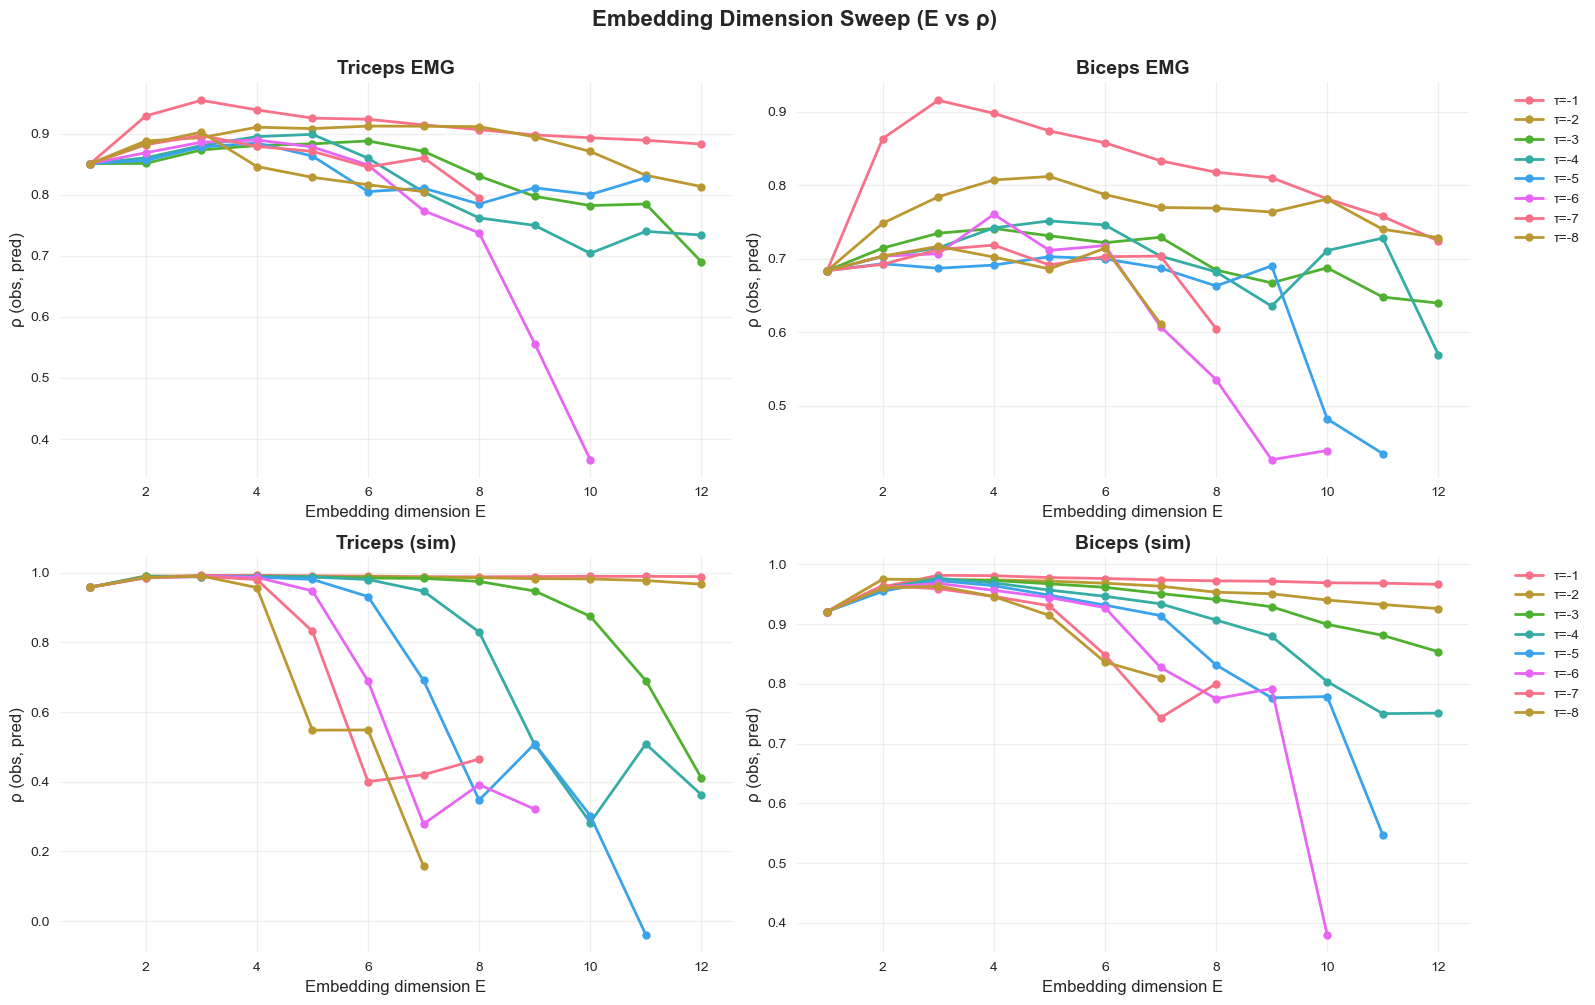


2. TAU SWEEP

Processing EMG data...
  Triceps EMG...
  Biceps EMG...

Processing Simulated data...
  Triceps (sim)...
  Biceps (sim)...


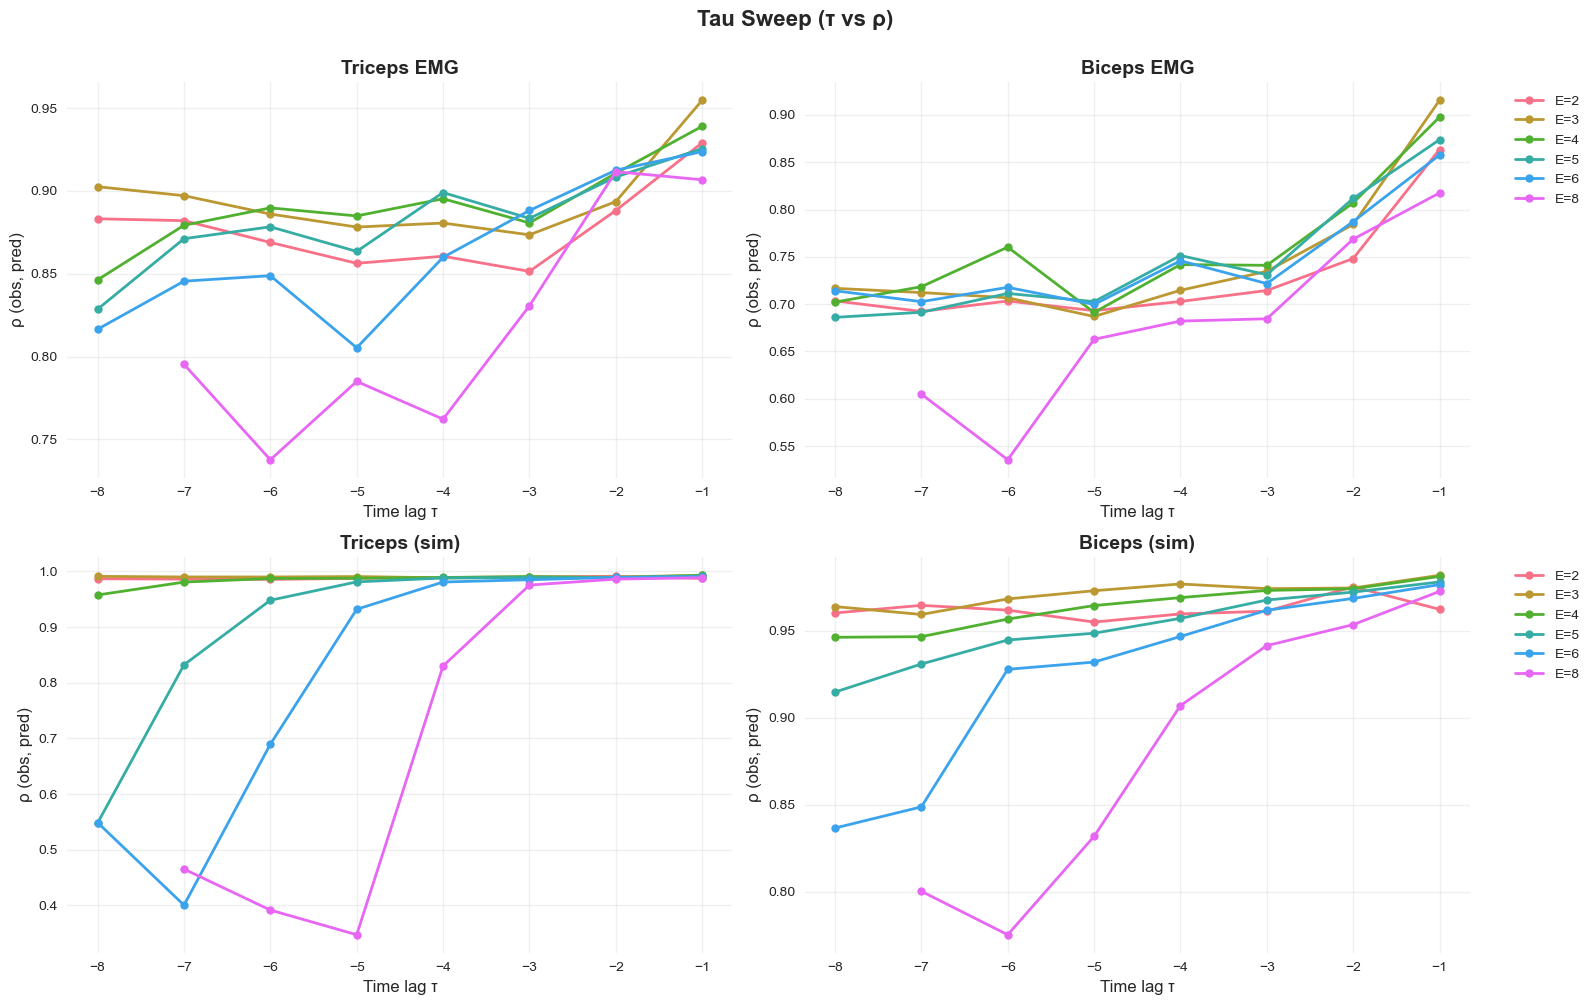


3. PREDICTION HORIZON SWEEP

Processing EMG data...
  Triceps EMG...
  Biceps EMG...

Processing Simulated data...
  Triceps (sim)...
  Biceps (sim)...


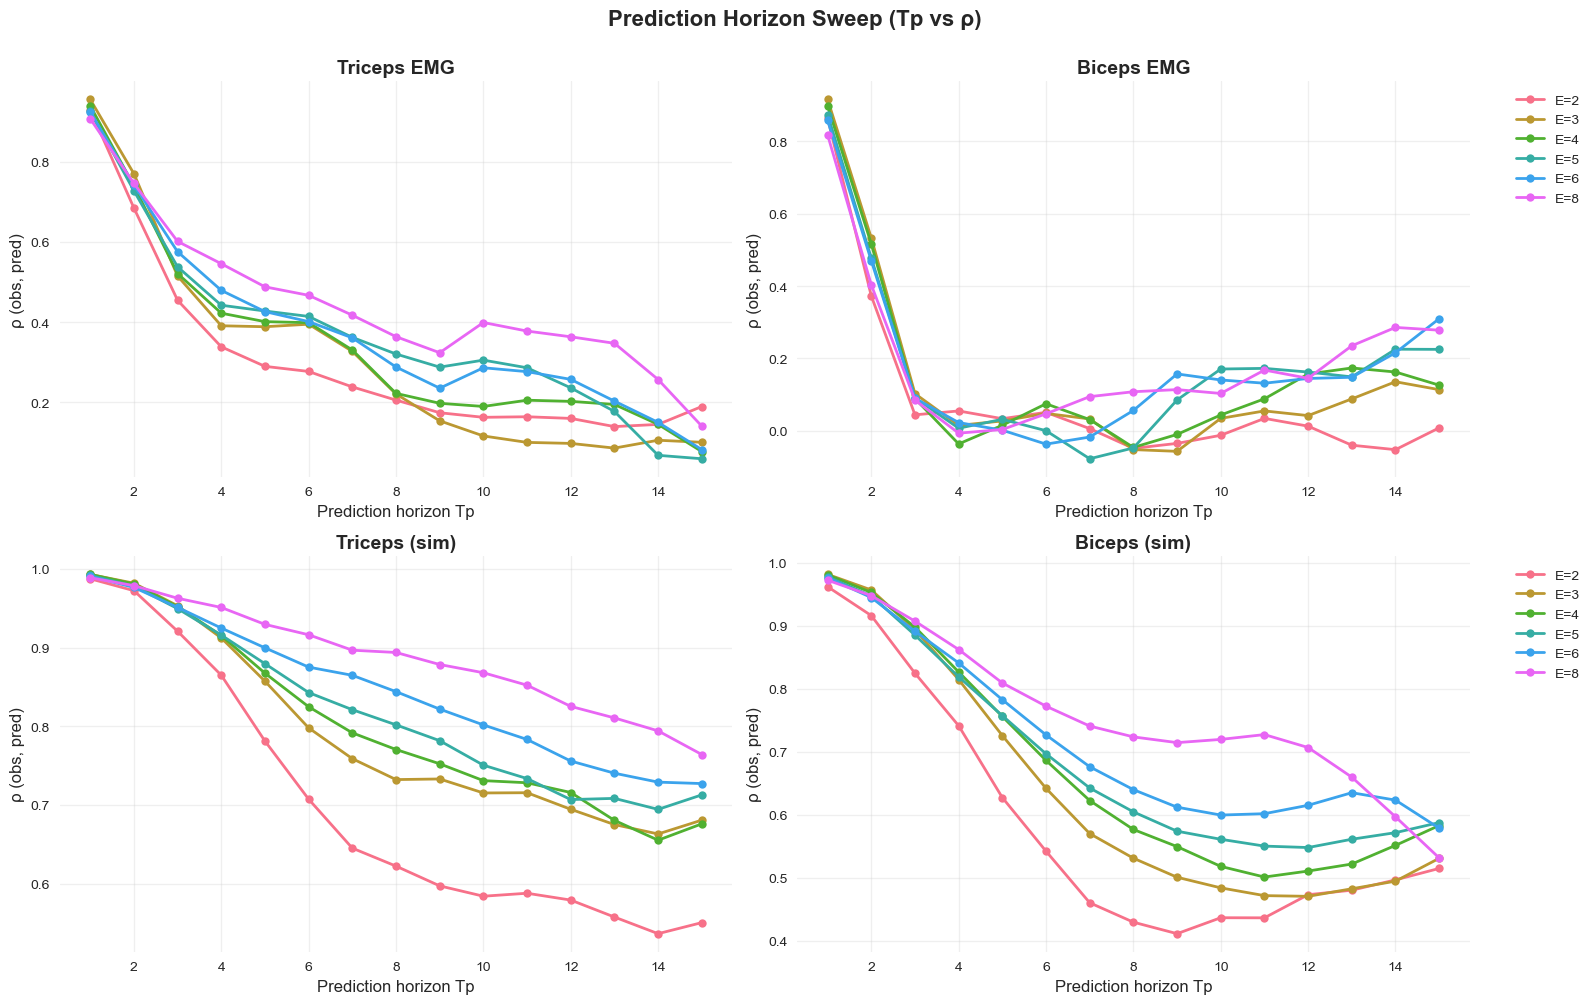


BEST PARAMETERS SUMMARY

EMG DATA

--- Best E (for each variable and τ, Tp=1) ---
   Variable  tau  E_best  rho_best
 Biceps EMG   -1       3  0.915356
 Biceps EMG   -2       5  0.811751
 Biceps EMG   -6       4  0.760266
 Biceps EMG   -4       5  0.751361
 Biceps EMG   -3       4  0.741029
 Biceps EMG   -7       4  0.718447
 Biceps EMG   -8       3  0.716737
 Biceps EMG   -5       5  0.702702
Triceps EMG   -1       3  0.954741
Triceps EMG   -2       6  0.912531
Triceps EMG   -8       3  0.902564
Triceps EMG   -4       5  0.899038
Triceps EMG   -7       3  0.897133
Triceps EMG   -6       4  0.889773
Triceps EMG   -3       6  0.888191
Triceps EMG   -5       4  0.884905

--- Best τ (for each variable and E, Tp=1) ---
   Variable  E  tau_best  rho_best
 Biceps EMG  3        -1  0.915356
 Biceps EMG  4        -1  0.897641
 Biceps EMG  5        -1  0.873723
 Biceps EMG  2        -1  0.863381
 Biceps EMG  6        -1  0.857552
 Biceps EMG  8        -1  0.817542
Triceps EMG  3        -1  0.9

In [19]:
# ========================================================================================
# SUPPLEMENTAL: PyEDM PARAMETER SWEEPS - EMG & Simulated Muscles
# ========================================================================================

print("\n" + "="*80)
print("PARAMETER SWEEPS FOR EMG & SIMULATED MUSCLES")
print("="*80)

# -------------------------------------------------------------------
# First, find valid data ranges
# -------------------------------------------------------------------
print("\nChecking data availability in big_df_all...")
print("\nEMG columns:")
for col in ["Triceps", "Biceps"]:
    valid_mask = big_df_all[col].notna()
    valid_indices = np.where(valid_mask)[0]
    if len(valid_indices) > 0:
        print(f"  {col}: {len(valid_indices)} valid points, range {valid_indices[0]} to {valid_indices[-1]}")
    else:
        print(f"  {col}: NO VALID DATA!")

print("\nSimulated muscle action columns:")
for col in ["act5", "act8"]:  # Triceps_Long, Biceps_Long
    valid_mask = big_df_all[col].notna()
    valid_indices = np.where(valid_mask)[0]
    if len(valid_indices) > 0:
        print(f"  {col}: {len(valid_indices)} valid points, range {valid_indices[0]} to {valid_indices[-1]}")
    else:
        print(f"  {col}: NO VALID DATA!")

# -------------------------------------------------------------------
# Config
# -------------------------------------------------------------------
# Define both EMG and simulated columns
analysis_configs = [
    ("EMG", ["Triceps", "Biceps"]),
    ("Simulated", ["act5", "act8"])  # Triceps_Long, Biceps_Long
]

column_labels = {
    "Triceps": "Triceps EMG",
    "Biceps": "Biceps EMG", 
    "act5": "Triceps (sim)",
    "act8": "Biceps (sim)"
}

Es = list(range(1, 13))  # Embedding dimension sweep
tau_list = [-1, -2, -3, -4, -5, -6, -7, -8]  # Embedding delay sweep
Tp_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # Prediction horizon sweep
min_pairs = 10

# Use the same lib/pred that was used in the main analysis
print(f"\nUsing lib: {lib}")
print(f"Using pred: {pred}")

def simplex_rho_self(df, col, lib, pred, E, tau, Tp):
    """Simplex self-prediction: columns=target=col; return Pearson rho."""
    try:
        pred_df = Simplex(
            dataFrame=df, lib=lib, pred=pred,
            columns=col, target=col,
            E=E, tau=tau, Tp=Tp,
            ignoreNan=True, showPlot=False
        )
        obs = pred_df["Observations"].to_numpy()
        hat = pred_df["Predictions"].to_numpy()
        return _safe_corr(obs, hat, min_pairs=min_pairs)
    except Exception as e:
        print(f"    Warning: {col} E={E}, tau={tau}, Tp={Tp} failed: {e}")
        return np.nan

# -------------------------------------------------------------------
# 1. EMBEDDING DIMENSION SWEEP (varying tau)
# -------------------------------------------------------------------
print("\n" + "="*80)
print("1. EMBEDDING DIMENSION SWEEP")
print("="*80)

E_results = {}  # (data_type, col, tau) -> pd.DataFrame with columns ["E","rho"]

for data_type, cols in analysis_configs:
    print(f"\nProcessing {data_type} data...")
    for col in cols:
        print(f"  {column_labels[col]}...")
        for tau in tau_list:
            rhos = []
            for E in Es:
                rho = simplex_rho_self(big_df_all, col, lib, pred, E=E, tau=tau, Tp=1)
                rhos.append(rho)
            E_results[(data_type, col, tau)] = pd.DataFrame({"E": Es, "rho": rhos})

# Plot E sweep - 2 rows (EMG, Simulated) x 2 cols (Triceps, Biceps)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for row_idx, (data_type, cols) in enumerate(analysis_configs):
    for col_idx, col in enumerate(cols):
        ax = axes[row_idx, col_idx]
        for tau in tau_list:
            df_ct = E_results[(data_type, col, tau)]
            ax.plot(df_ct["E"], df_ct["rho"], marker="o", linewidth=2, markersize=6, label=f"τ={tau}")
        ax.set_title(f"{column_labels[col]}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Embedding dimension E", fontsize=12)
        ax.set_ylabel("ρ (obs, pred)", fontsize=12)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=10)
        if col_idx == 1:  # Only show legend on right column
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=10)

plt.suptitle("Embedding Dimension Sweep (E vs ρ)", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUT_DIR / "supplemental_E_sweep.png", dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# 2. TAU SWEEP (varying E)
# -------------------------------------------------------------------
print("\n" + "="*80)
print("2. TAU SWEEP")
print("="*80)

tau_results = {}  # (data_type, col, E) -> pd.DataFrame with columns ["tau","rho"]
E_test_values = [2, 3, 4, 5, 6, 8]  # Select a few E values to test

for data_type, cols in analysis_configs:
    print(f"\nProcessing {data_type} data...")
    for col in cols:
        print(f"  {column_labels[col]}...")
        for E in E_test_values:
            rhos = []
            for tau in tau_list:
                rho = simplex_rho_self(big_df_all, col, lib, pred, E=E, tau=tau, Tp=1)
                rhos.append(rho)
            tau_results[(data_type, col, E)] = pd.DataFrame({"tau": tau_list, "rho": rhos})

# Plot tau sweep
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for row_idx, (data_type, cols) in enumerate(analysis_configs):
    for col_idx, col in enumerate(cols):
        ax = axes[row_idx, col_idx]
        for E in E_test_values:
            df_ce = tau_results[(data_type, col, E)]
            ax.plot(df_ce["tau"], df_ce["rho"], marker="o", linewidth=2, markersize=6, label=f"E={E}")
        ax.set_title(f"{column_labels[col]}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Time lag τ", fontsize=12)
        ax.set_ylabel("ρ (obs, pred)", fontsize=12)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=10)
        if col_idx == 1:  # Only show legend on right column
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=10)

plt.suptitle("Tau Sweep (τ vs ρ)", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUT_DIR / "supplemental_tau_sweep.png", dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# 3. PREDICTION HORIZON SWEEP (Tp)
# -------------------------------------------------------------------
print("\n" + "="*80)
print("3. PREDICTION HORIZON SWEEP")
print("="*80)

Tp_results = {}  # (data_type, col, E) -> pd.DataFrame with columns ["Tp","rho"]

for data_type, cols in analysis_configs:
    print(f"\nProcessing {data_type} data...")
    for col in cols:
        print(f"  {column_labels[col]}...")
        for E in E_test_values:
            rhos = []
            for Tp in Tp_list:
                rho = simplex_rho_self(big_df_all, col, lib, pred, E=E, tau=-1, Tp=Tp)
                rhos.append(rho)
            Tp_results[(data_type, col, E)] = pd.DataFrame({"Tp": Tp_list, "rho": rhos})

# Plot Tp sweep
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for row_idx, (data_type, cols) in enumerate(analysis_configs):
    for col_idx, col in enumerate(cols):
        ax = axes[row_idx, col_idx]
        for E in E_test_values:
            df_ce = Tp_results[(data_type, col, E)]
            ax.plot(df_ce["Tp"], df_ce["rho"], marker="o", linewidth=2, markersize=6, label=f"E={E}")
        ax.set_title(f"{column_labels[col]}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Prediction horizon Tp", fontsize=12)
        ax.set_ylabel("ρ (obs, pred)", fontsize=12)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=10)
        if col_idx == 1:  # Only show legend on right column
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=10)

plt.suptitle("Prediction Horizon Sweep (Tp vs ρ)", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUT_DIR / "supplemental_Tp_sweep.png", dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# 4. SUMMARY TABLES
# -------------------------------------------------------------------
print("\n" + "="*80)
print("BEST PARAMETERS SUMMARY")
print("="*80)

for data_type, cols in analysis_configs:
    print(f"\n{'='*80}")
    print(f"{data_type.upper()} DATA")
    print(f"{'='*80}")
    
    # Best E per column and tau
    print(f"\n--- Best E (for each variable and τ, Tp=1) ---")
    summary_E = []
    for col in cols:
        for tau in tau_list:
            df_ct = E_results[(data_type, col, tau)]
            i_best = int(np.nanargmax(df_ct["rho"].to_numpy()))
            E_best = int(df_ct["E"].iloc[i_best])
            rho_best = float(df_ct["rho"].iloc[i_best])
            summary_E.append({"Variable": column_labels[col], "tau": tau, "E_best": E_best, "rho_best": rho_best})
    
    summary_E_df = pd.DataFrame(summary_E).sort_values(["Variable", "rho_best"], ascending=[True, False])
    print(summary_E_df.to_string(index=False))
    
    # Best tau per column and E
    print(f"\n--- Best τ (for each variable and E, Tp=1) ---")
    summary_tau = []
    for col in cols:
        for E in E_test_values:
            df_ce = tau_results[(data_type, col, E)]
            i_best = int(np.nanargmax(df_ce["rho"].to_numpy()))
            tau_best = int(df_ce["tau"].iloc[i_best])
            rho_best = float(df_ce["rho"].iloc[i_best])
            summary_tau.append({"Variable": column_labels[col], "E": E, "tau_best": tau_best, "rho_best": rho_best})
    
    summary_tau_df = pd.DataFrame(summary_tau).sort_values(["Variable", "rho_best"], ascending=[True, False])
    print(summary_tau_df.to_string(index=False))
    
    # Best Tp per column and E
    print(f"\n--- Best Tp (for each variable and E, τ=-1) ---")
    summary_Tp = []
    for col in cols:
        for E in E_test_values:
            df_ce = Tp_results[(data_type, col, E)]
            i_best = int(np.nanargmax(df_ce["rho"].to_numpy()))
            Tp_best = int(df_ce["Tp"].iloc[i_best])
            rho_best = float(df_ce["rho"].iloc[i_best])
            summary_Tp.append({"Variable": column_labels[col], "E": E, "Tp_best": Tp_best, "rho_best": rho_best})
    
    summary_Tp_df = pd.DataFrame(summary_Tp).sort_values(["Variable", "rho_best"], ascending=[True, False])
    print(summary_Tp_df.to_string(index=False))

print("\n" + "="*80)
print("PARAMETER SWEEPS COMPLETE")
print("="*80)

In [20]:
# path to your HDF5 file
H5_DATA_PATH = Path('/root/vast/joshua/track-mjx/data/neurIPS-paramsweep/reproducibility_runs/rewards_actions.h5')

data = []
with h5py.File(H5_DATA_PATH, 'r') as F:

    # loop through each top-level group in the HDF5 file
    for key in F.keys():
        group = F[key]

        # load datasets inside the group
        actions_highfreq = group['action'][()]
        joint_reward = group['joint_reward'][:]
    
        # parse the group name to extract seed, ctrlcost, energy
        split_name = key.split('_')

        # append extracted and computed values into a list of dicts
        data.append({
            'seed' :     split_name[0].split('-')[-1],  # e.g., "seed-200" -> "200"
            'ctrlcost' : split_name[1].split('-')[-1],  # e.g., "ctrl-0.300" -> "0.300"
            'energy' :   split_name[2].split('-')[-1],  # e.g., "energy-0.400" -> "0.400"
            'max-rewards' : np.mean(joint_reward),
            'actions' :  actions_highfreq,
        })

# convert to dataframe
data = pd.DataFrame(data)
data['max-rewards-norm'] = data['max-rewards'] / data['max-rewards'].max()
data = data.sort_values(['ctrlcost', 'energy']).reset_index(drop=True)